# Tropycal v0.3 Sample Code

Version 0.3 of Tropycal was released on 8 September 2021! This Jupyter notebook walks through sample Tropycal usage as well as highlighting some of the new features of this release.

Let's start as always with importing the relevant modules from Tropycal:

In [1]:
from tropycal import tracks, utils, rain

For this code, we'll retrieve the North Atlantic HURDATv2 dataset, along with Best Track data such that we can include this year's storms as well.

In [2]:
basin = tracks.TrackDataset(include_btk=True)

--> Starting to read in HURDAT2 data
--> Completed reading in HURDAT2 data (6.31 seconds)
--> Starting to read in best track data
--> Completed reading in best track data (3.81 seconds)


## Storm plotting tools

This release has several updates to Tropycal's plotting capability, some of which are not backwards compatible. The next few steps will highlight these features.

Let's first retrieve an instance of a Storm object for Hurricane Michael (2018):

In [3]:
storm = basin.get_storm(('michael',2018))

Now that we have an instance of a Storm object stored in this variable called "storm", we can access all of its attributes and methods as listed in the Tropycal documentation (recently updated to include v0.3).

The biggest non-backwards compatible change is that "return_ax" is no longer an argument. By default, all plotting functions (except for Recon and Tornado) return the axes instance generated for the plot.

Let's make a simple plot of Hurricane Michael's track:

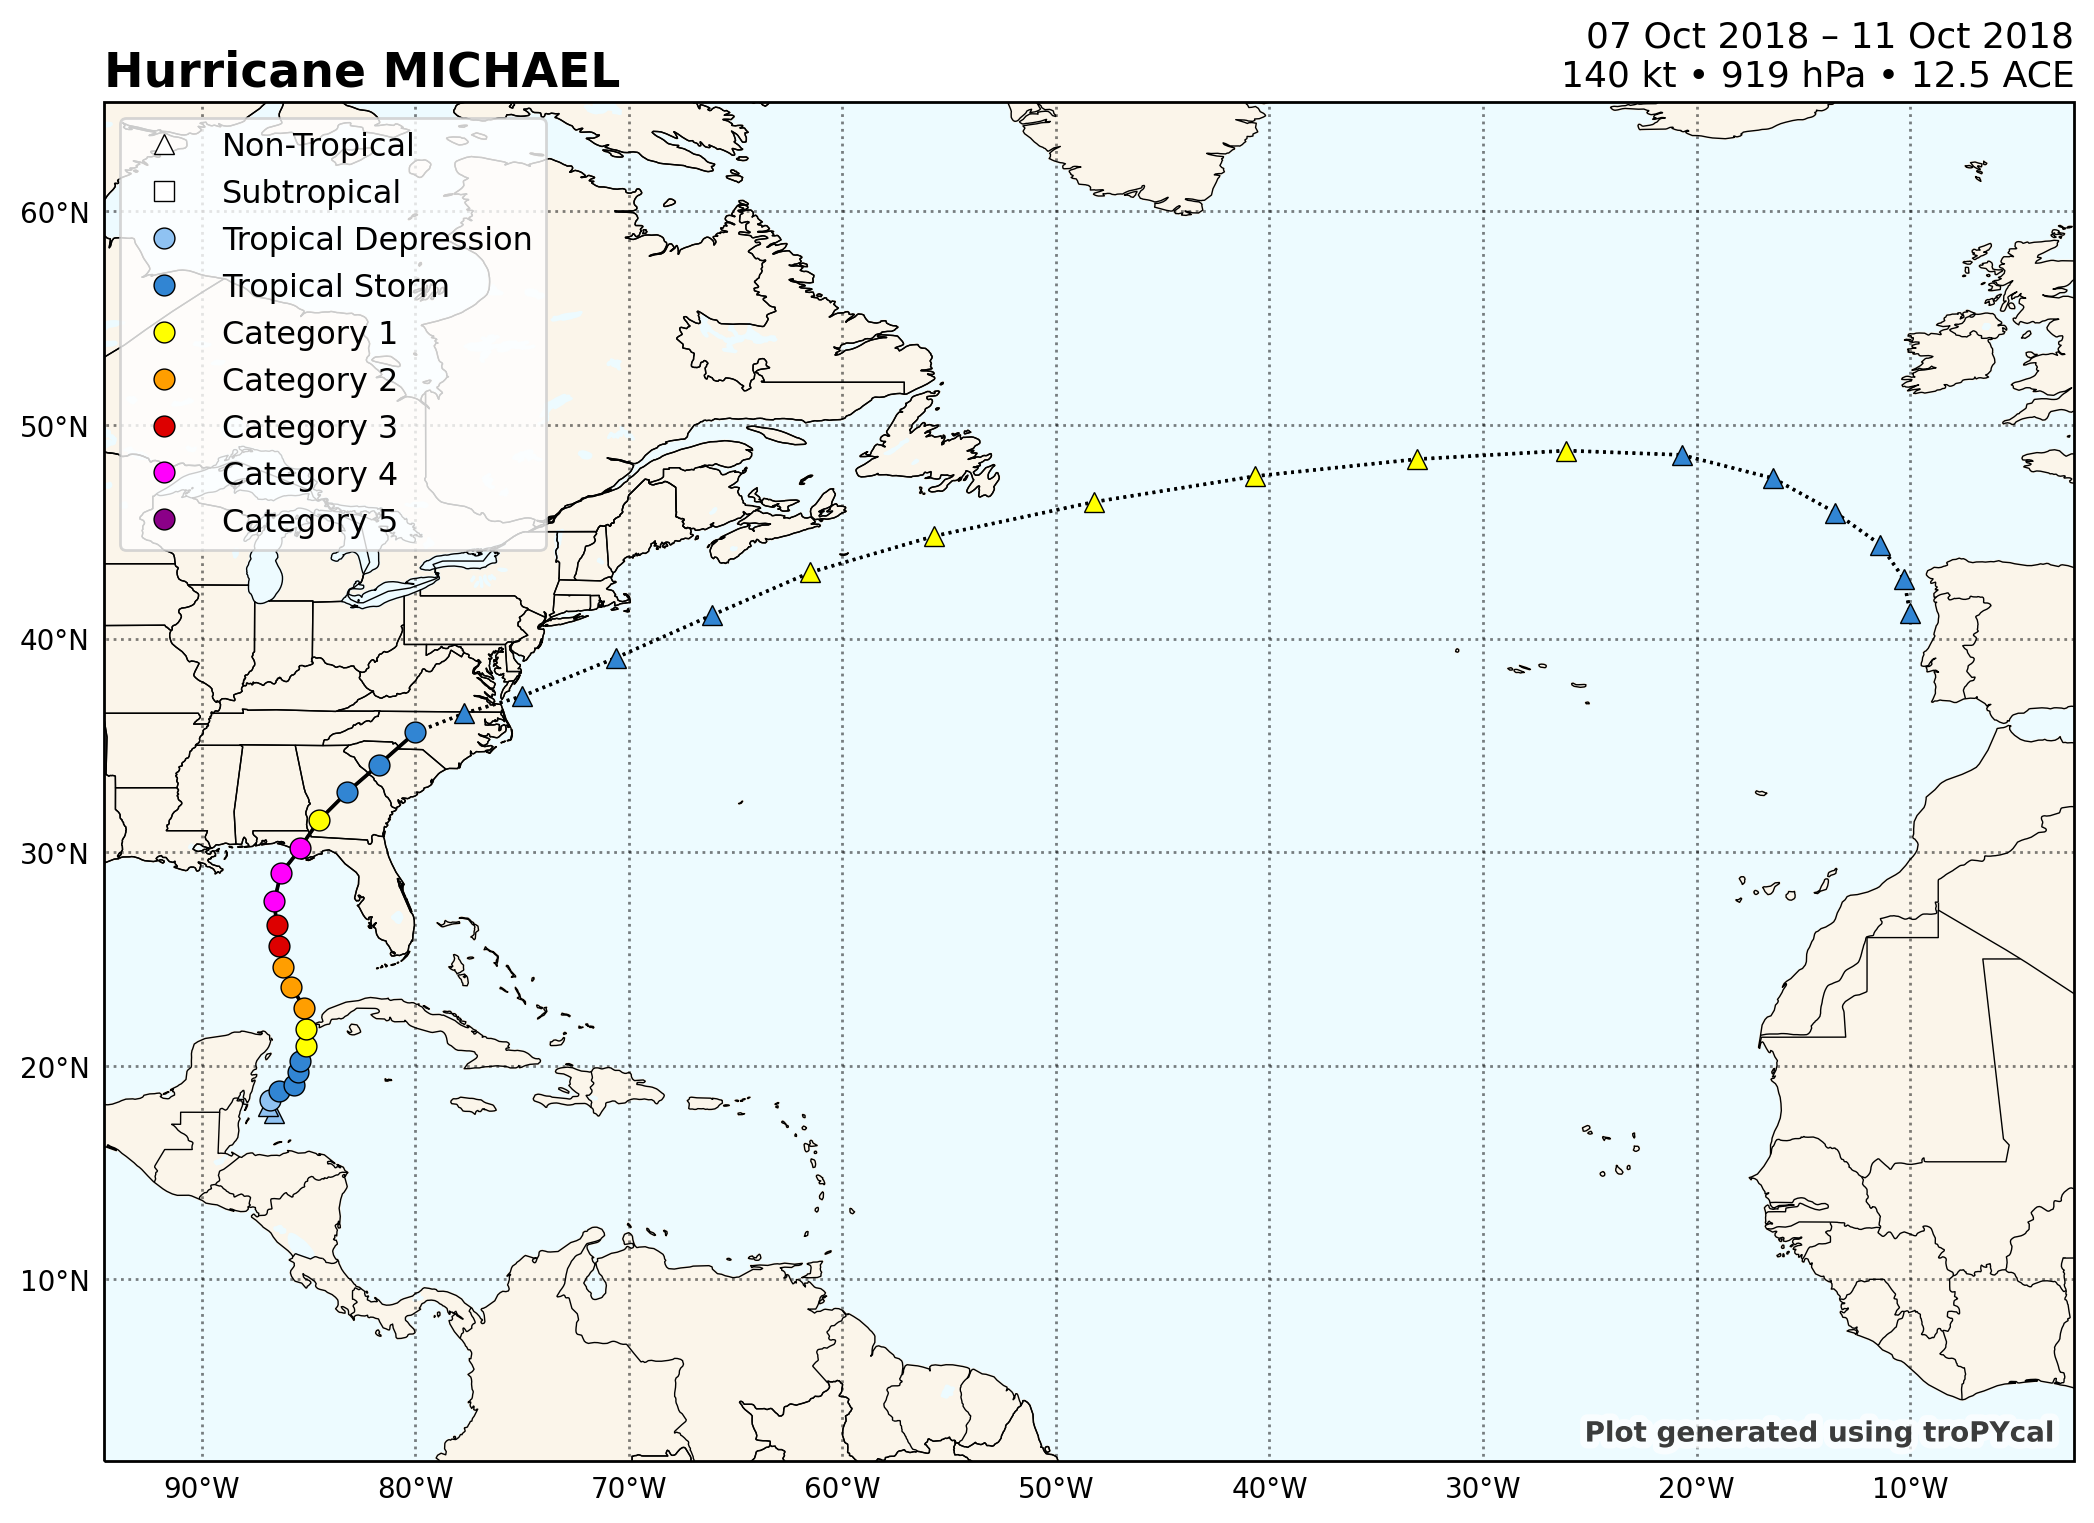

In [4]:
storm.plot()

Now let's experiment with the plot customization settings. The plot above shows Michael's entire life span, but a large portion of its track was spent as an extratropical cyclone.

Let's narrow its track down to only the duration it was a tropical cyclone:

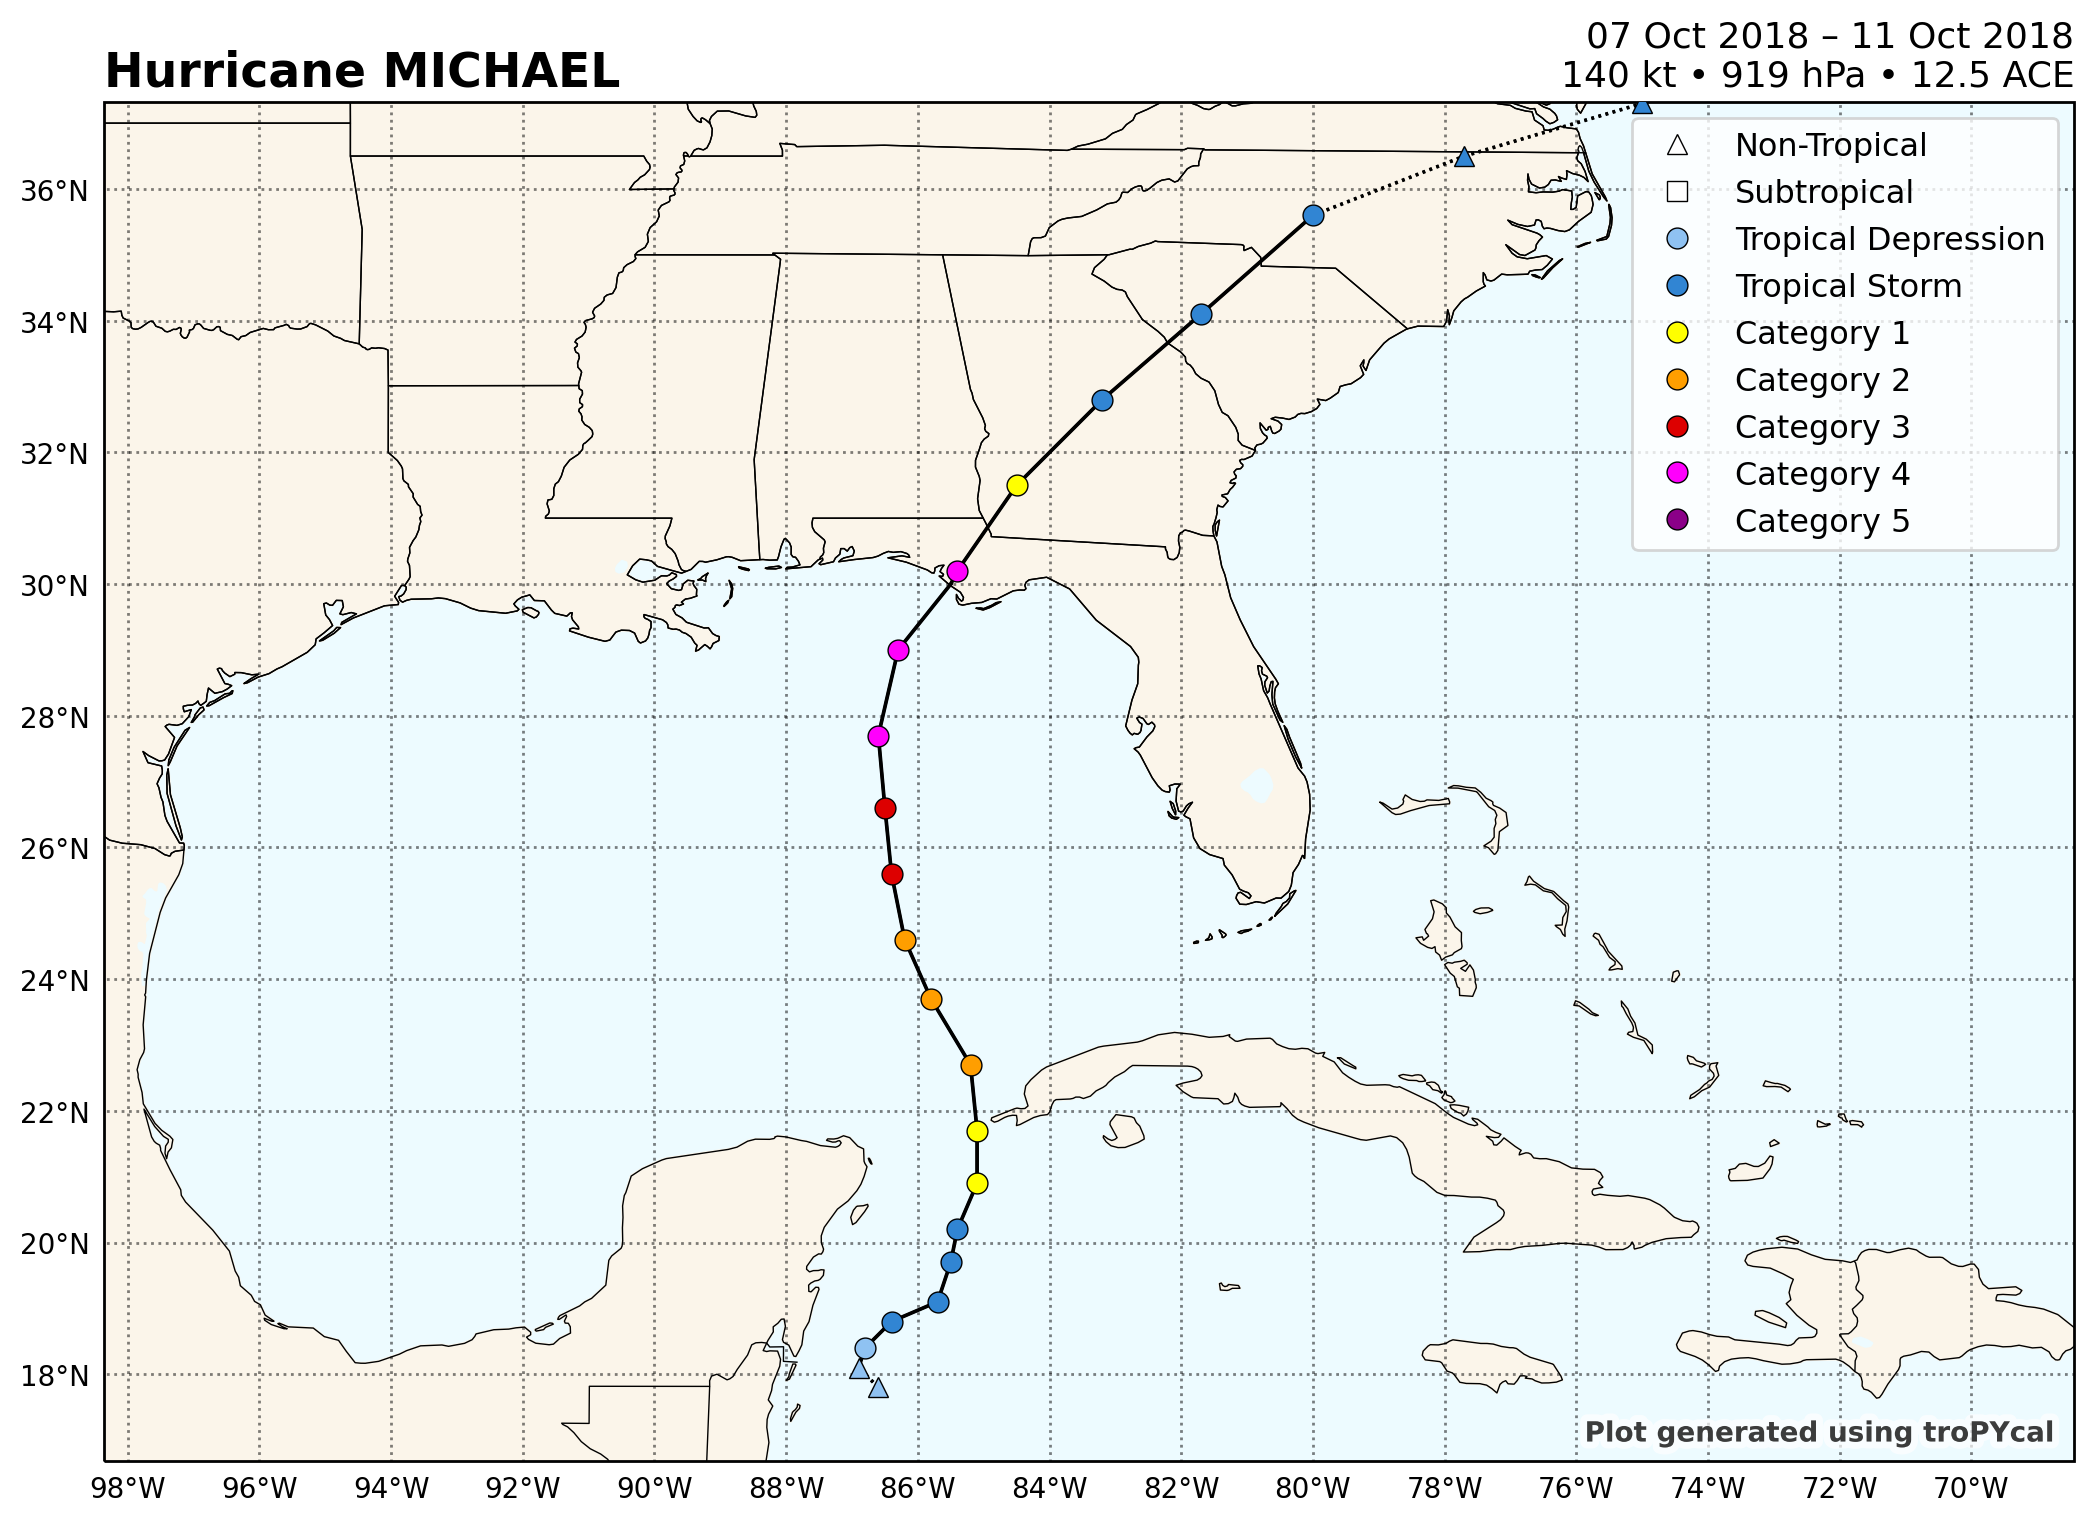

In [5]:
storm.plot(domain='dynamic_tropical')

You may recall that Hurricane Michael peaked as a Category 5 hurricane - but none of the dots above show this. This is because Michael only reached Category 5 intensity in between the standard 00/06/12/18 UTC updates in HURDATv2.

By default, storm dots are only plotted in 6-hour increments. We can use the "plot_all_dots" argument to get around this:

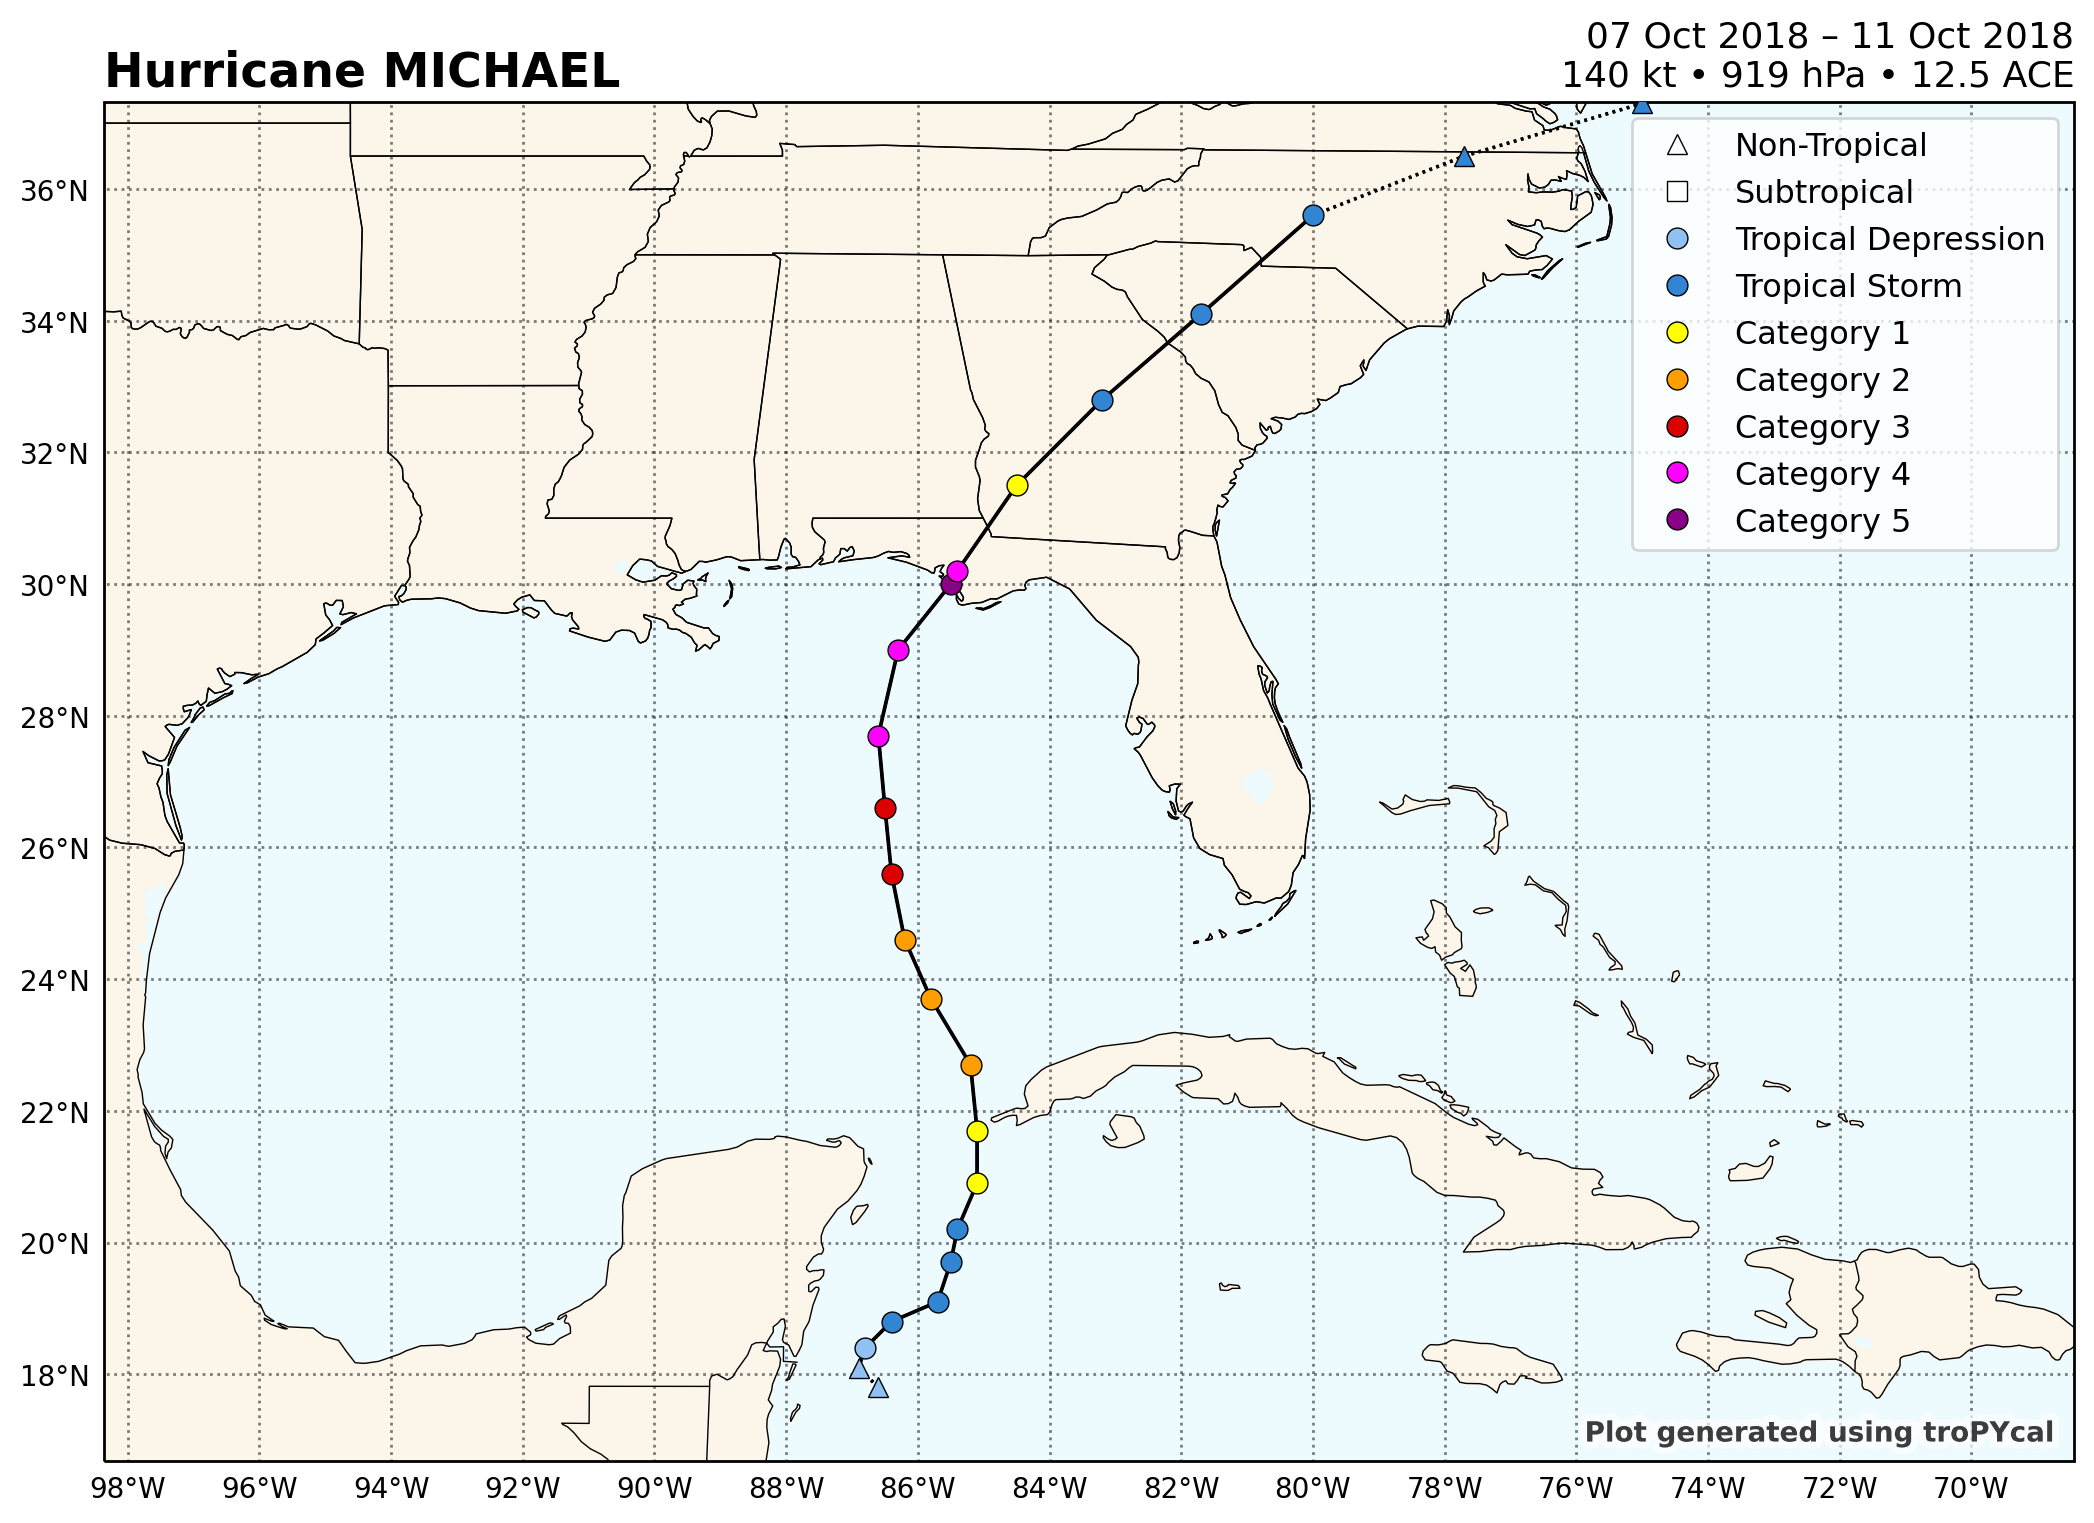

In [6]:
storm.plot(domain='dynamic_tropical',plot_all_dots=True)

Now we can see Michael's peak as a Category 5 hurricane right as it made landfall.

Alternatively, we can color-code the track by SSHWS wind scale:

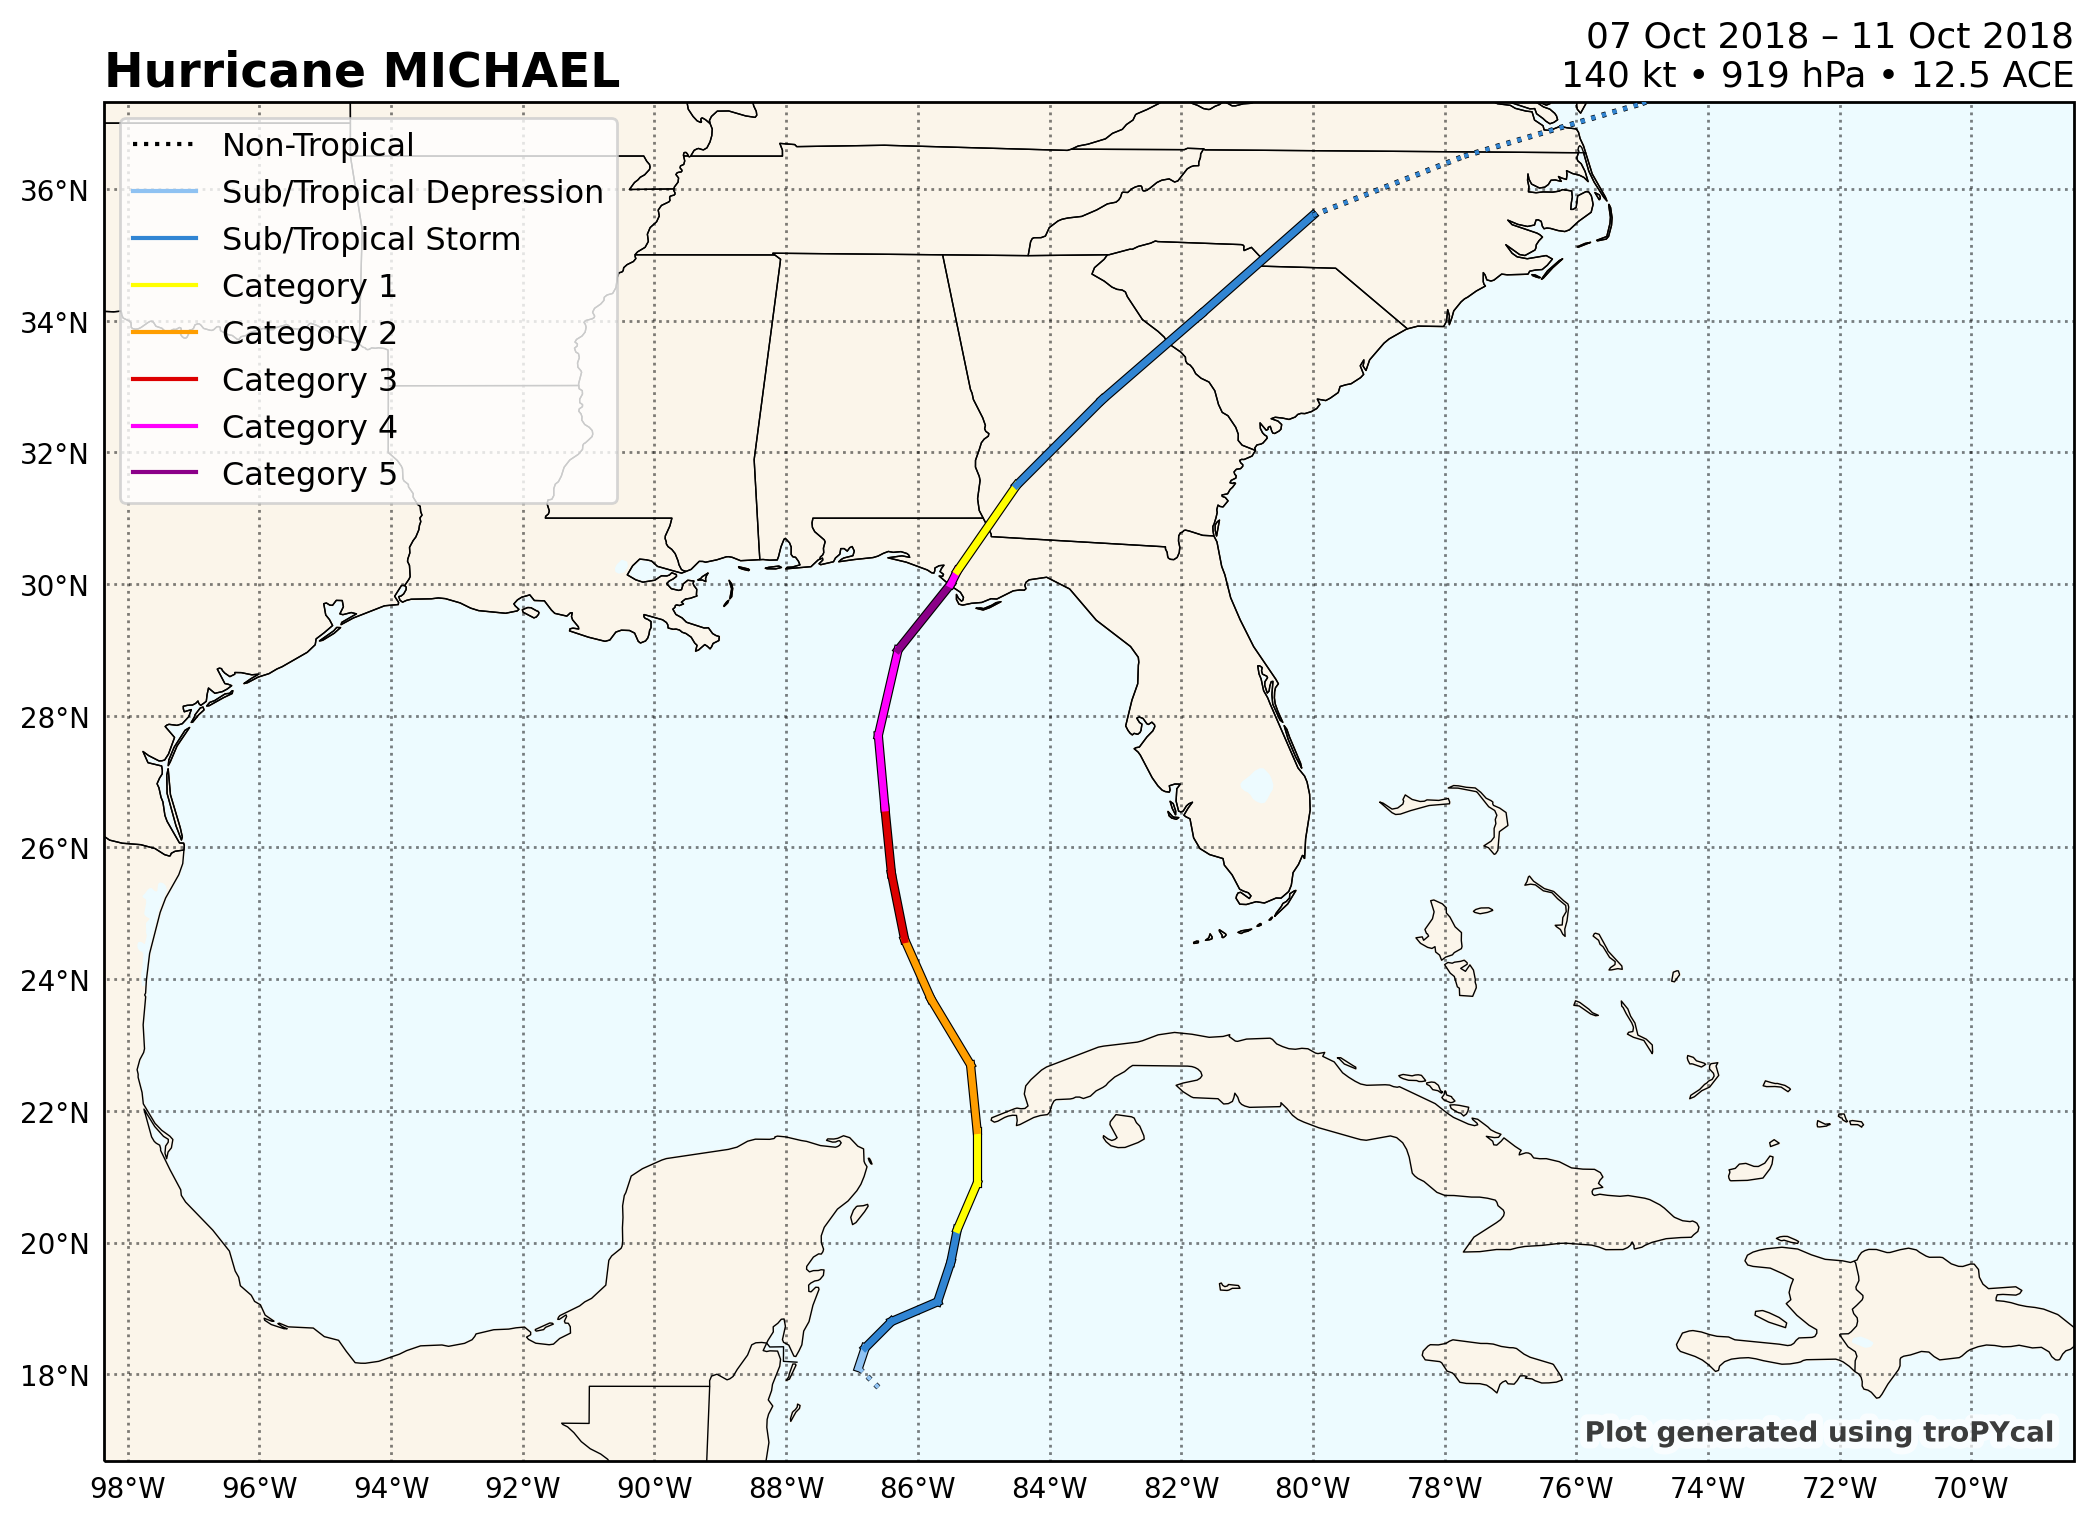

In [7]:
storm.plot(domain='dynamic_tropical',prop={'dots':False,'linecolor':'category','linewidth':2.5})

Recall how previously, we noted all plotting functions return the axes instance. Let's make use of this functionality to annotate where Michael reached its peak intensity on top of the same axes:

Text(-85.0, 29.0, 'Peak:\n140 kt')

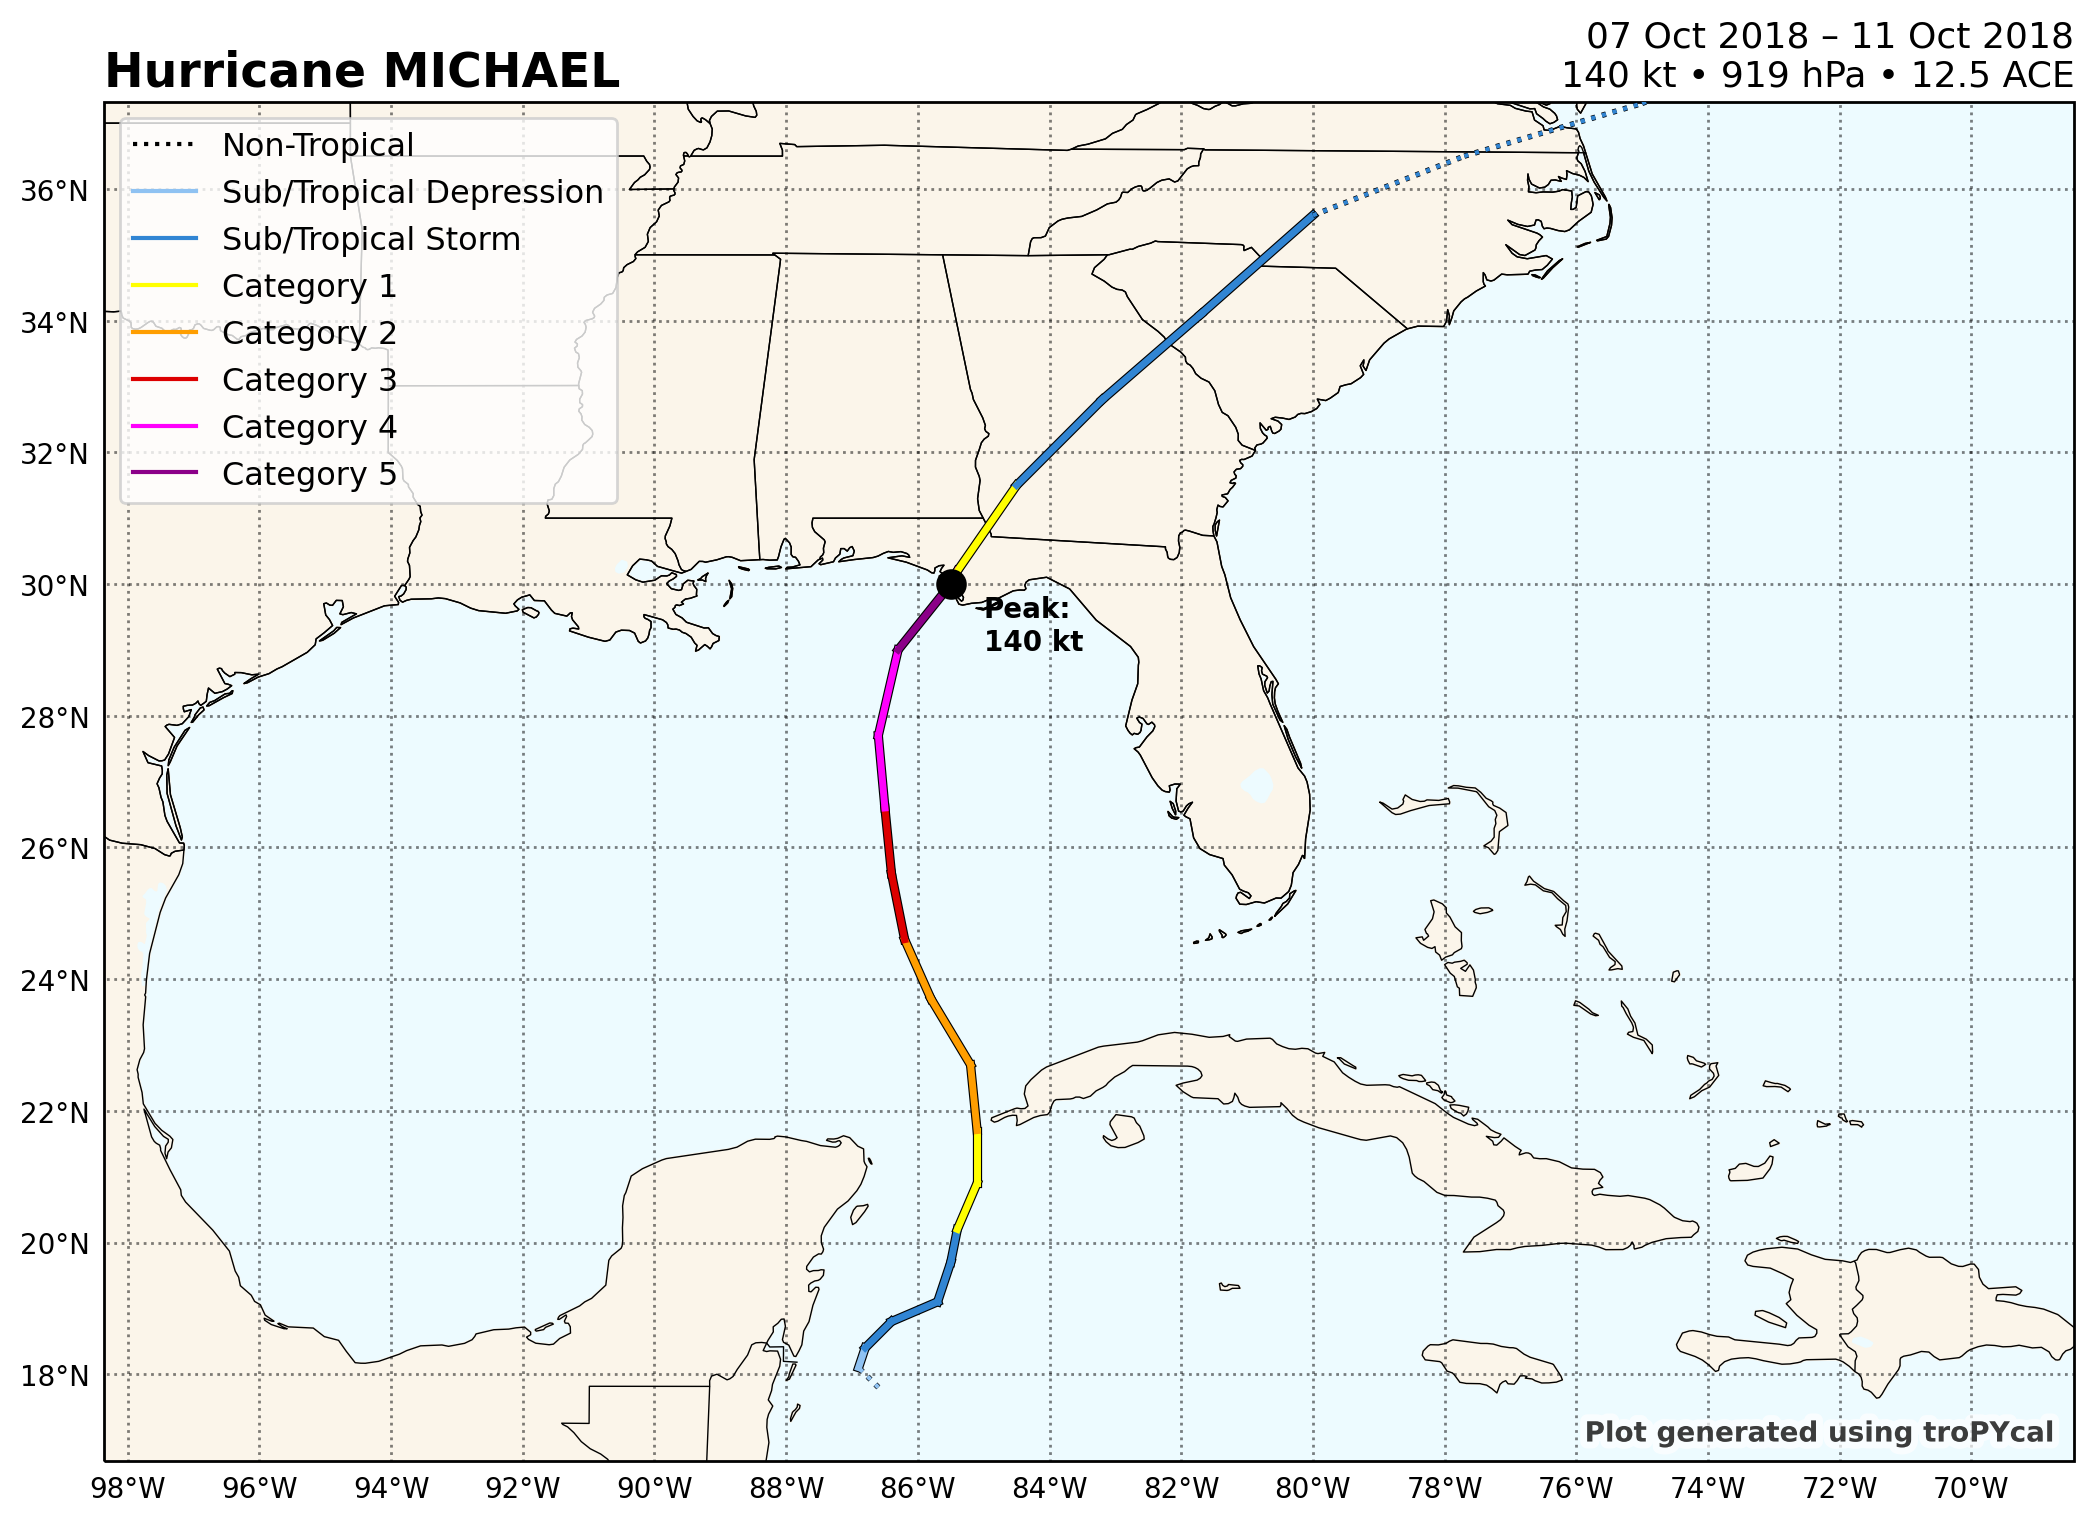

In [8]:
#Import relevant packages
import numpy as np
import cartopy.crs as ccrs

#Calculating Michael's maximum sustained wind - the result will be 140 kt
storm_vmax = int(np.nanmax(storm.vmax))

#Subsetting the Storm object to only when Michael was at this intensity
storm_subset = storm.sel(vmax=(storm_vmax,storm_vmax))

#Retrieving the lat and lon at the time Michael reached its peak intensity
peak_lon = storm_subset.lon[0]
peak_lat = storm_subset.lat[0]

#Plotting the storm track - but this time store the axes instance for further plotting
ax = storm.plot(domain='dynamic_tropical',prop={'dots':False,'linecolor':'category','linewidth':2.5})

#Plotting and annotating Michael's peak location
ax.plot(peak_lon,peak_lat,'o',ms=10,mfc='k',mec='k',zorder=10,transform=ccrs.PlateCarree())
ax.annotate(f"Peak:\n{storm_vmax} kt",(peak_lon,peak_lat),(peak_lon+0.5,peak_lat-1),fontweight='bold',transform=ccrs.PlateCarree())

Now that we've plotted one storm, let's try plotting *two* storms on the same plot!

For this, we will go back to our "basin" variable, as it contains all storms in HURDATv2. Let's compare Hurricane Katrina (2005) and Hurricane Ida (2021), including labeling the storm names on the plot:

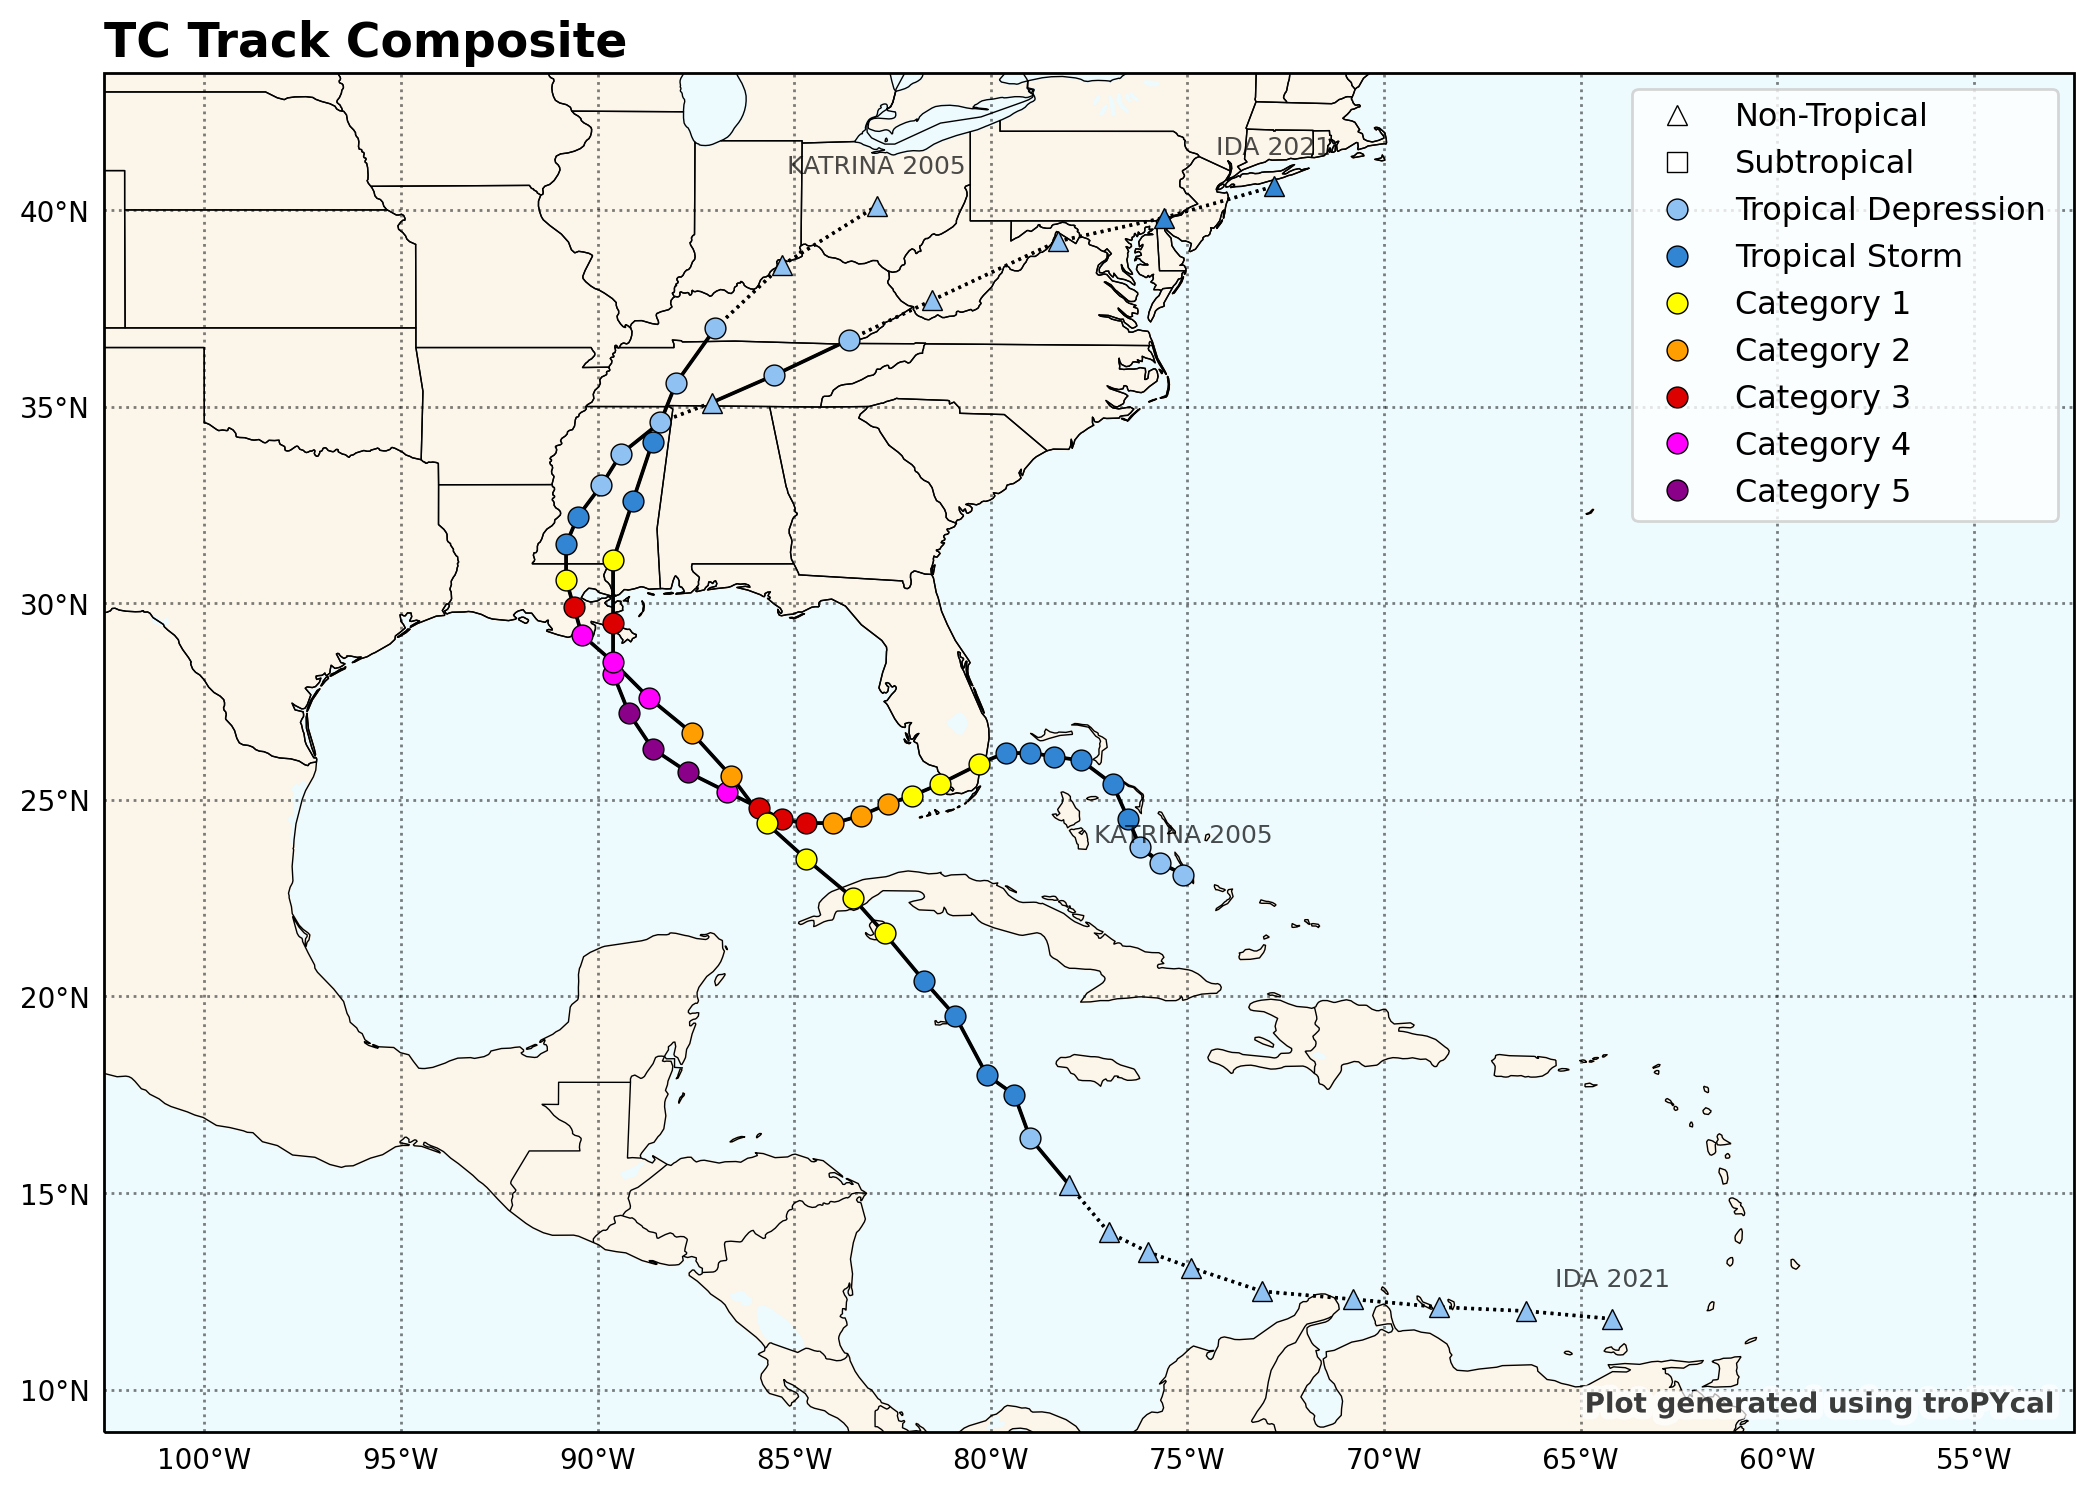

In [9]:
basin.plot_storms([('katrina',2005),('ida',2021)],labels=True)

Let's zoom in on Louisiana to compare their tracks:

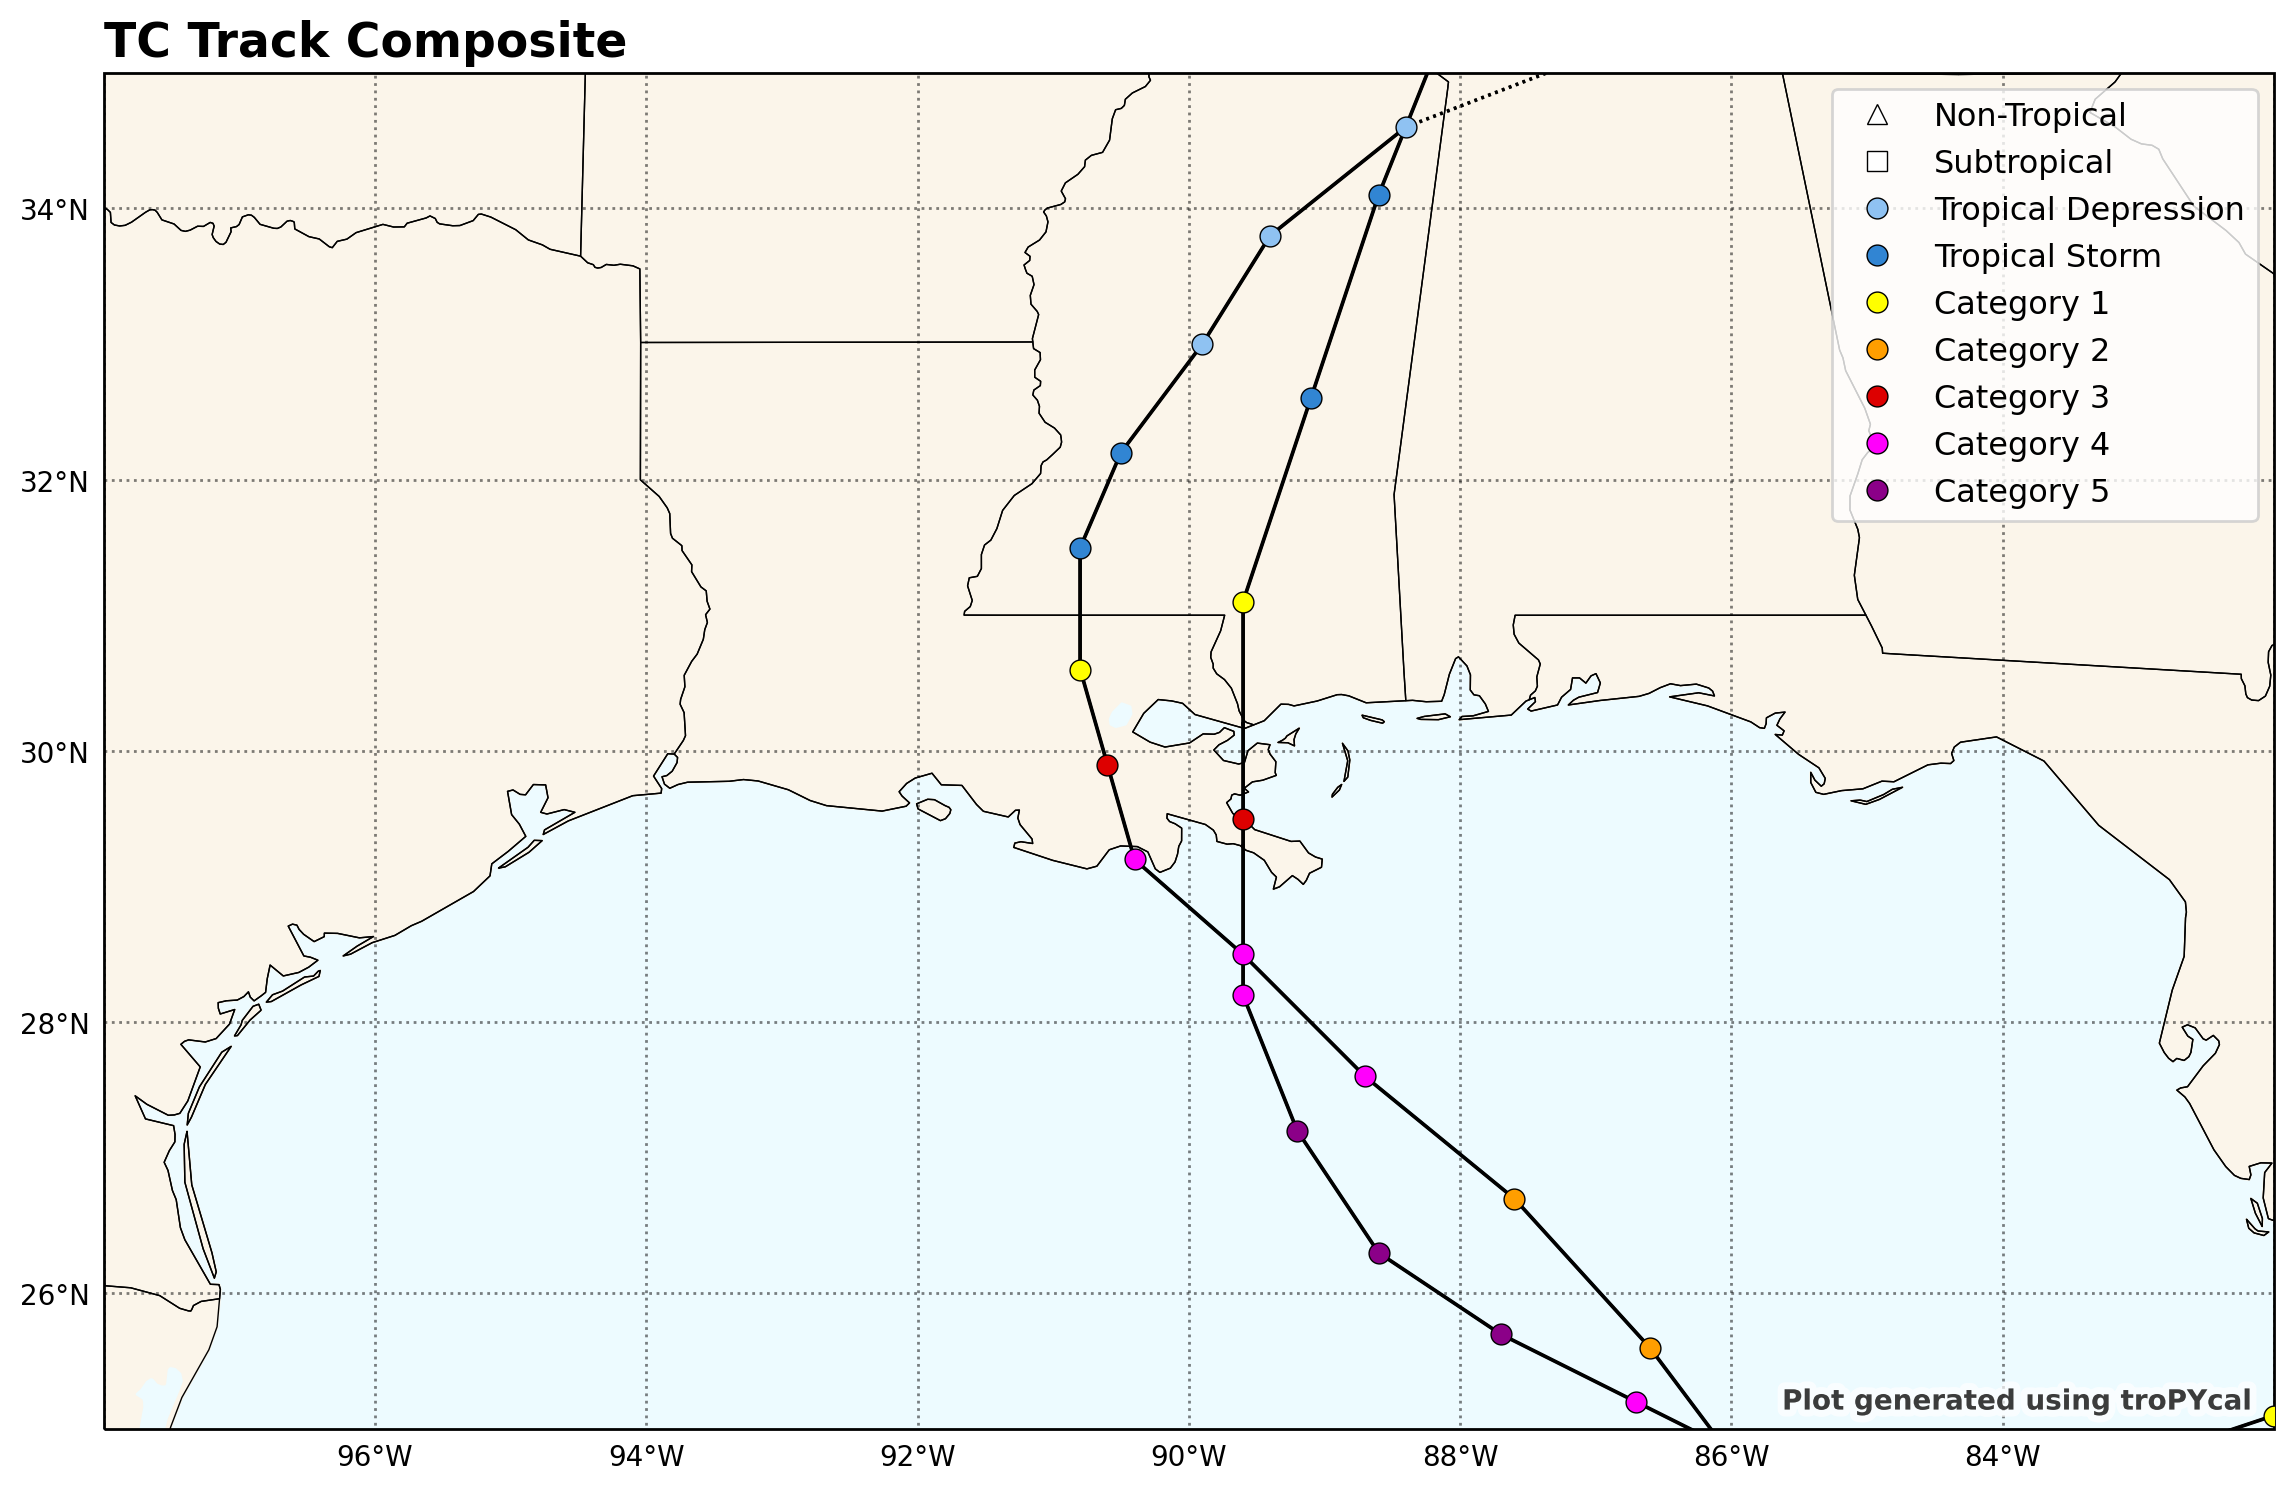

In [10]:
basin.plot_storms([('katrina',2005),('ida',2021)],labels=True,domain={'s':25,'n':35,'w':-98,'e':-82})

## Quick Plotting Tools

A new addition to Tropycal v0.3 is a quick Cartopy plotting utility, for users that want to bypass the built-in plotting functionality and quickly add a Storm track to their plot.

Let's make a simple Cartopy projection over the Gulf of Mexico:

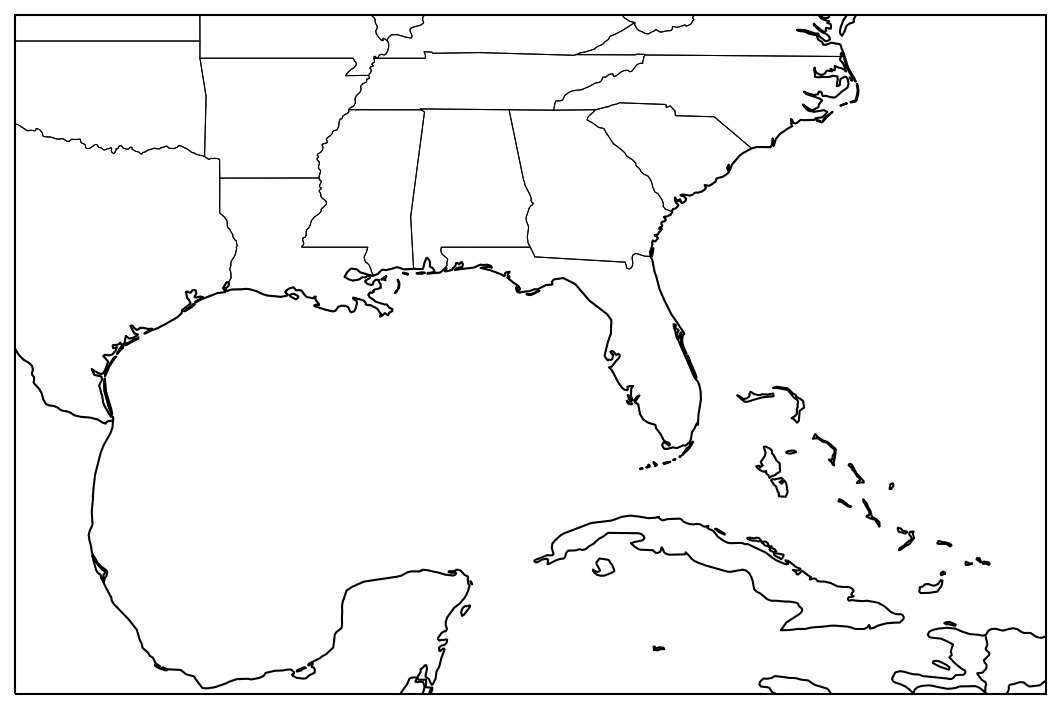

In [11]:
#Import necessary packages
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

#Create a PlateCarree Cartopy projection
proj = ccrs.PlateCarree()

#Create an instance of figure and axes
fig = plt.figure(figsize=(9,6),dpi=150)
ax = plt.axes(projection=proj)

#Plot coastlines
states = ax.add_feature(cfeature.STATES.with_scale('50m'),linewidths=0.5,linestyle='solid',edgecolor='k')
countries = ax.add_feature(cfeature.BORDERS.with_scale('50m'),linewidths=1.0,linestyle='solid',edgecolor='k')
coastlines = ax.add_feature(cfeature.COASTLINE.with_scale('50m'),linewidths=1.0,linestyle='solid',edgecolor='k')

#Zoom in over the Gulf Coast
ax.set_extent([-100,-70,18,37])

#Show plot and close
plt.show()
plt.close()

Now, we can simply use our new Cartopy utility tools to quickly plot Hurricane Michael's track on this plot:

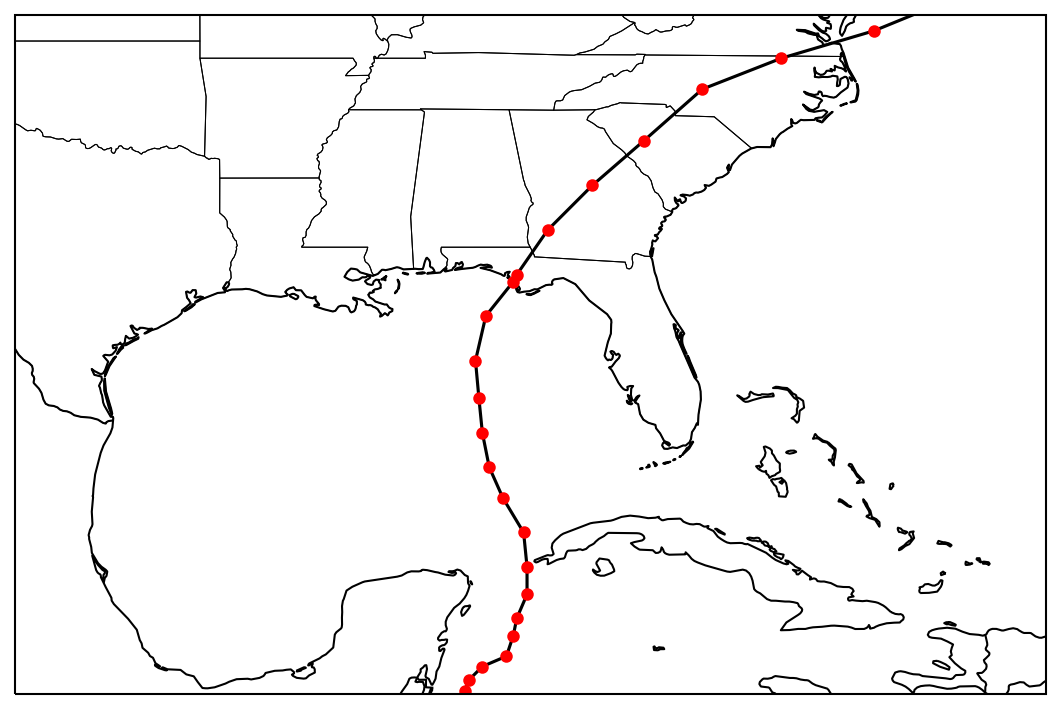

In [12]:
#Import necessary packages
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

#Create a PlateCarree Cartopy projection
proj = ccrs.PlateCarree()

#Create an instance of figure and axes
fig = plt.figure(figsize=(9,6),dpi=150)
ax = plt.axes(projection=proj)

#Plot coastlines
states = ax.add_feature(cfeature.STATES.with_scale('50m'),linewidths=0.5,linestyle='solid',edgecolor='k')
countries = ax.add_feature(cfeature.BORDERS.with_scale('50m'),linewidths=1.0,linestyle='solid',edgecolor='k')
coastlines = ax.add_feature(cfeature.COASTLINE.with_scale('50m'),linewidths=1.0,linestyle='solid',edgecolor='k')

#Add Tropycal functionality to ax
ax = utils.add_tropycal(ax)

#Plot Hurricane Michael (2018)'s track and observation dots
storm = basin.get_storm(('michael',2018))
ax.plot_storm(storm,'-',color='k')
ax.plot_storm(storm,'o',ms=5,color='r')

#Zoom in over the Gulf Coast
ax.set_extent([-100,-70,18,37])

#Show plot and close
plt.show()
plt.close()

## Tropical Cyclone Rainfall

Tropical cyclones are known to produce heavy rainfall, with at times catastrophic flooding. The Weather Prediction Center (WPC) routinely issues advisories on tropical cyclones or their remnants inland, and maintains a database of rainfall associated with tropical cyclones in the US.

This dataset is now available in CSV format, and can be easily read into Tropycal using the new Rain module:

In [13]:
rain_obj = rain.RainDataset()

--> Starting to read in rainfall data
--> Completed reading in rainfall data (7.57 seconds)


Hurricane Harvey (2017) produced catastrophic flooding over Texas. Let's pull its rain observations to take a deeper look:

In [14]:
storm = basin.get_storm(('harvey',2017))
harvey_rain = rain_obj.get_storm_rainfall(storm)

Now let's look through the pandas DataFrame containing Harvey's rainfall:

In [15]:
harvey_rain

Station  Total    Lat    Lon
261570  ABEL                     5 SW    1.79  33.60 -85.65
261571  ADDISON                          2.17  34.20 -87.18
261572  ALABASTER                        1.42  33.18 -86.78
261573  ALBERTVILLE                      1.63  34.24 -86.19
261574  ALEXANDER CITY                   2.46  32.95 -85.95
...                                ...    ...    ...    ...
268375  WHITE SULPHUR SPRINGS            1.14  37.80 -80.48
268376  WHITE SULPHUR SPRINGS            0.96  37.80 -80.30
268377  WHITMER                  3 W     0.20  38.82 -79.60
268378  WILLIAMSON                       0.61  37.67 -82.28
268379  WOLF PEN                         0.40  37.53 -81.58

[6797 rows x 4 columns]

We can use Pandas' DataFrame utility to rearrange this by the "Total" column (representing rainfall in inches) to see the highest rain total associated with Harvey - which gives us 60.58 inches near Nederland.

In [16]:
harvey_rain.sort_values('Total',ascending=False)

Station  Total        Lat        Lon
267161                Nederland 1.5 SW  60.58  29.950000 -94.010000
266354                    Groves 1.3 N  60.54  29.960000 -93.920000
266199                     Friendswood  56.00  29.500000 -95.200000
267575                  Santa Fe 3 ENE  54.77  29.390000 -95.050000
265621                     Friendswood  54.00  29.745100 -95.566600
...                                ...    ...        ...        ...
263372  MADISON                          0.00  39.430000 -92.170000
266215                Fulshear 2.7 WNW   0.00  29.707364 -95.939681
263375  MARSHALL                         0.00  39.130000 -93.220000
263376  MARSHFIELD                       0.00  37.340000 -92.900000
263374  MANSFIELD                        0.00  37.120000 -92.580000

[6797 rows x 4 columns]

Let's interpolate Harvey's rain to a grid with 0.1 degree resolution, and plot the grid:

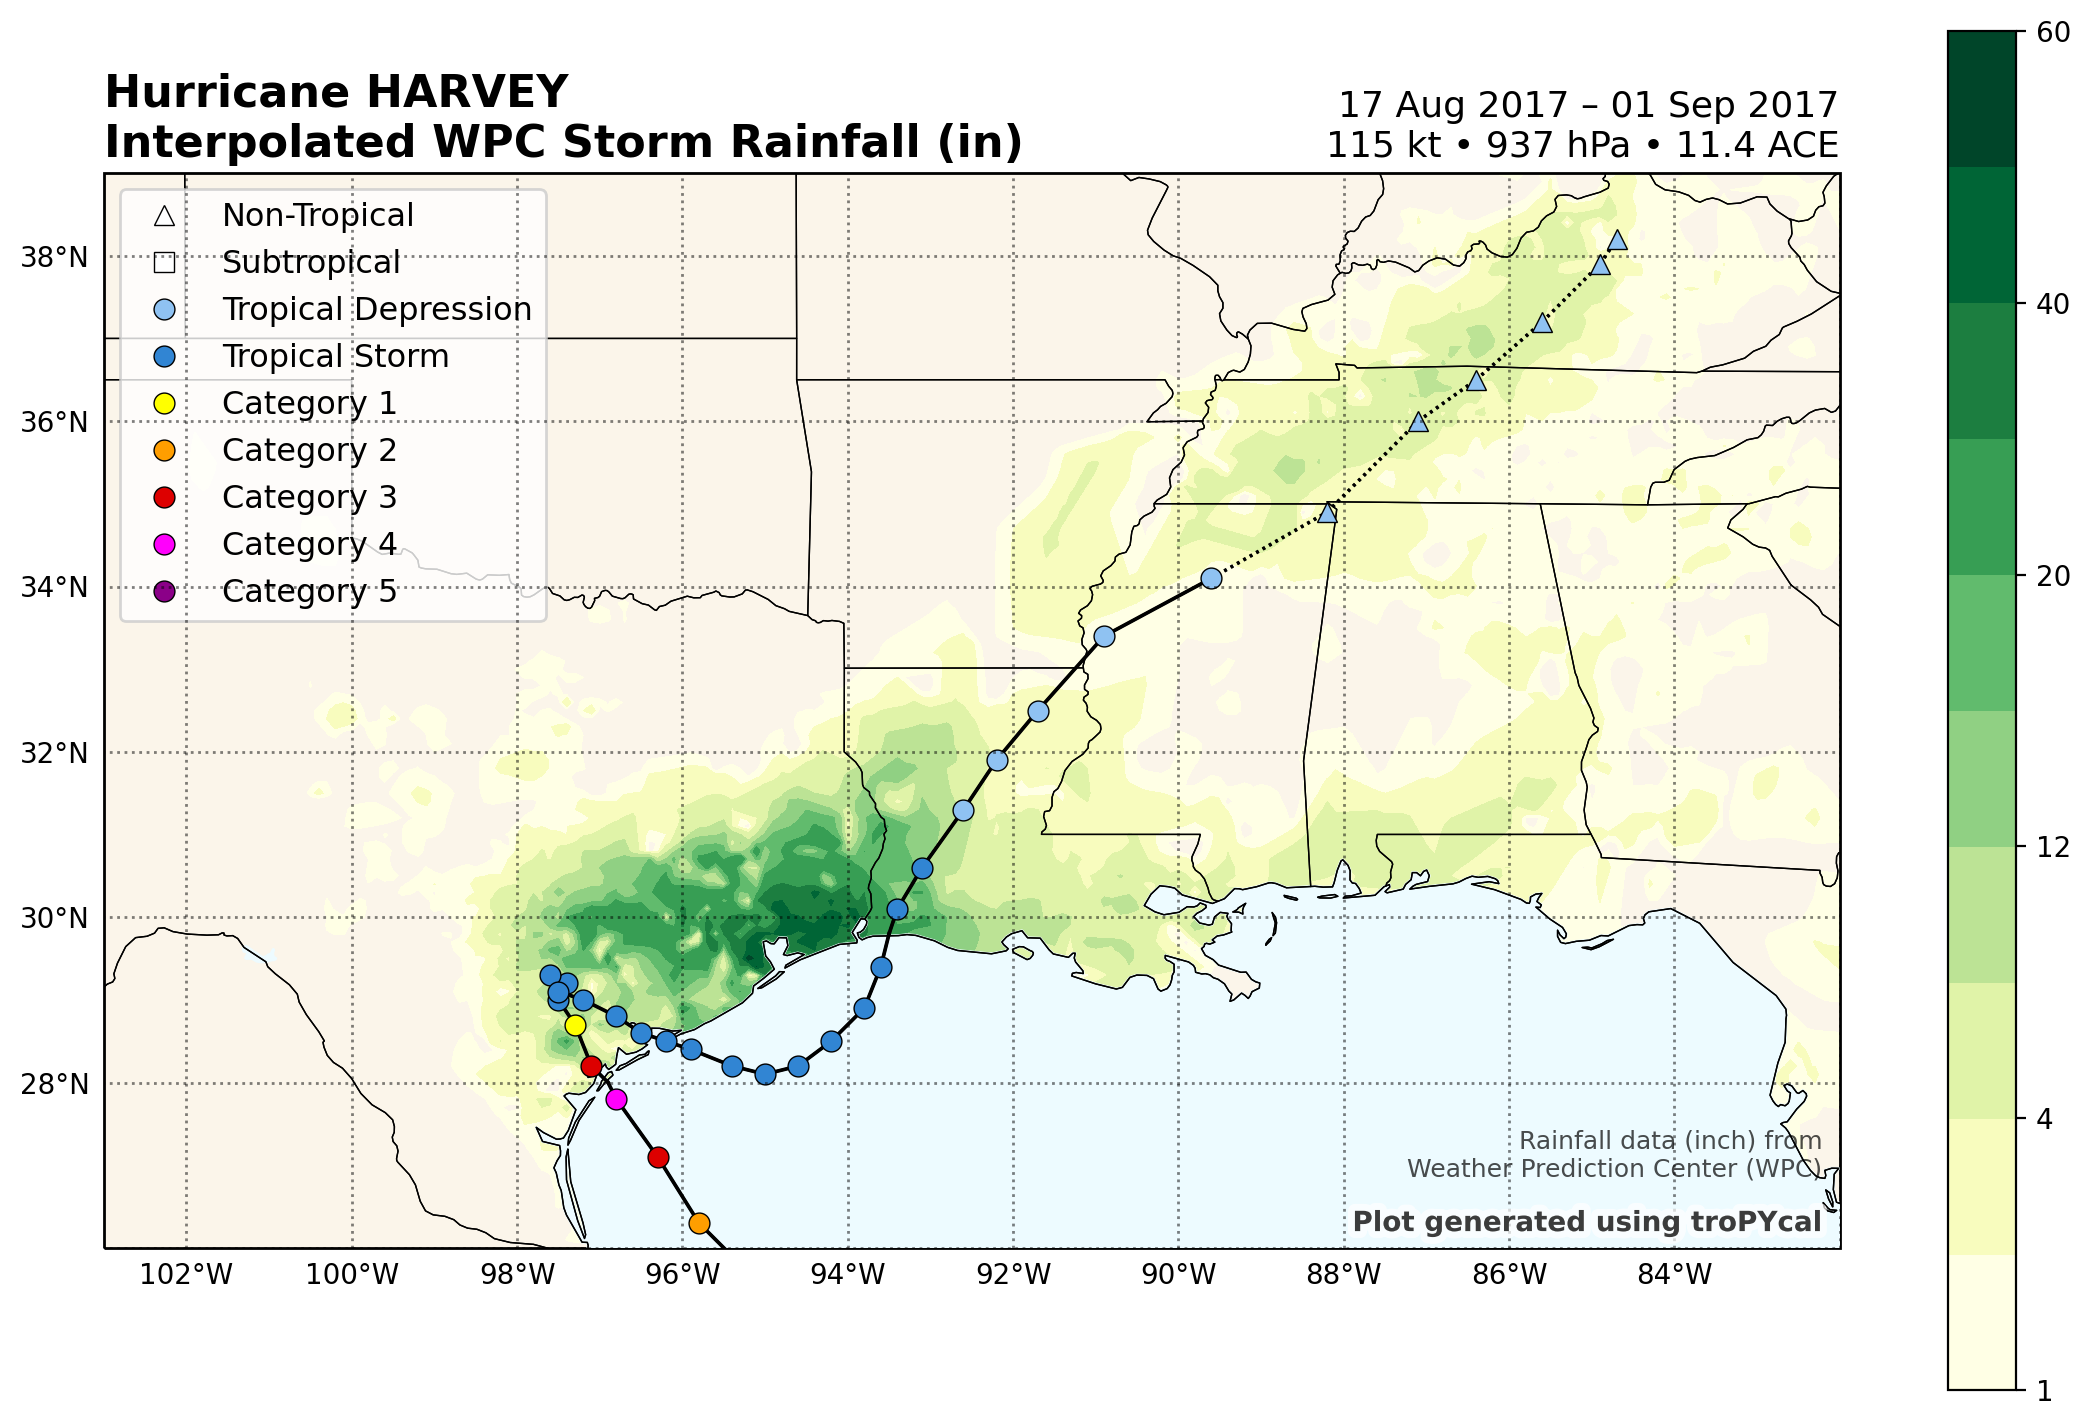

In [17]:
#Interpolate to grid
grid = rain_obj.interpolate_to_grid(storm,return_xarray=True)

#Plot grid
levels = [1,2,4,8,12,16,20,30,40,50,60]
rain_obj.plot_rain_grid(storm,grid,levels,domain={'s':26,'n':39,'w':-103,'e':-82})

Linear interpolation isn't perfect of course, especially considering that some observations in this dataset aren't perfectly quality controlled.

To compensate, we can also plot the individual rain observation dots:

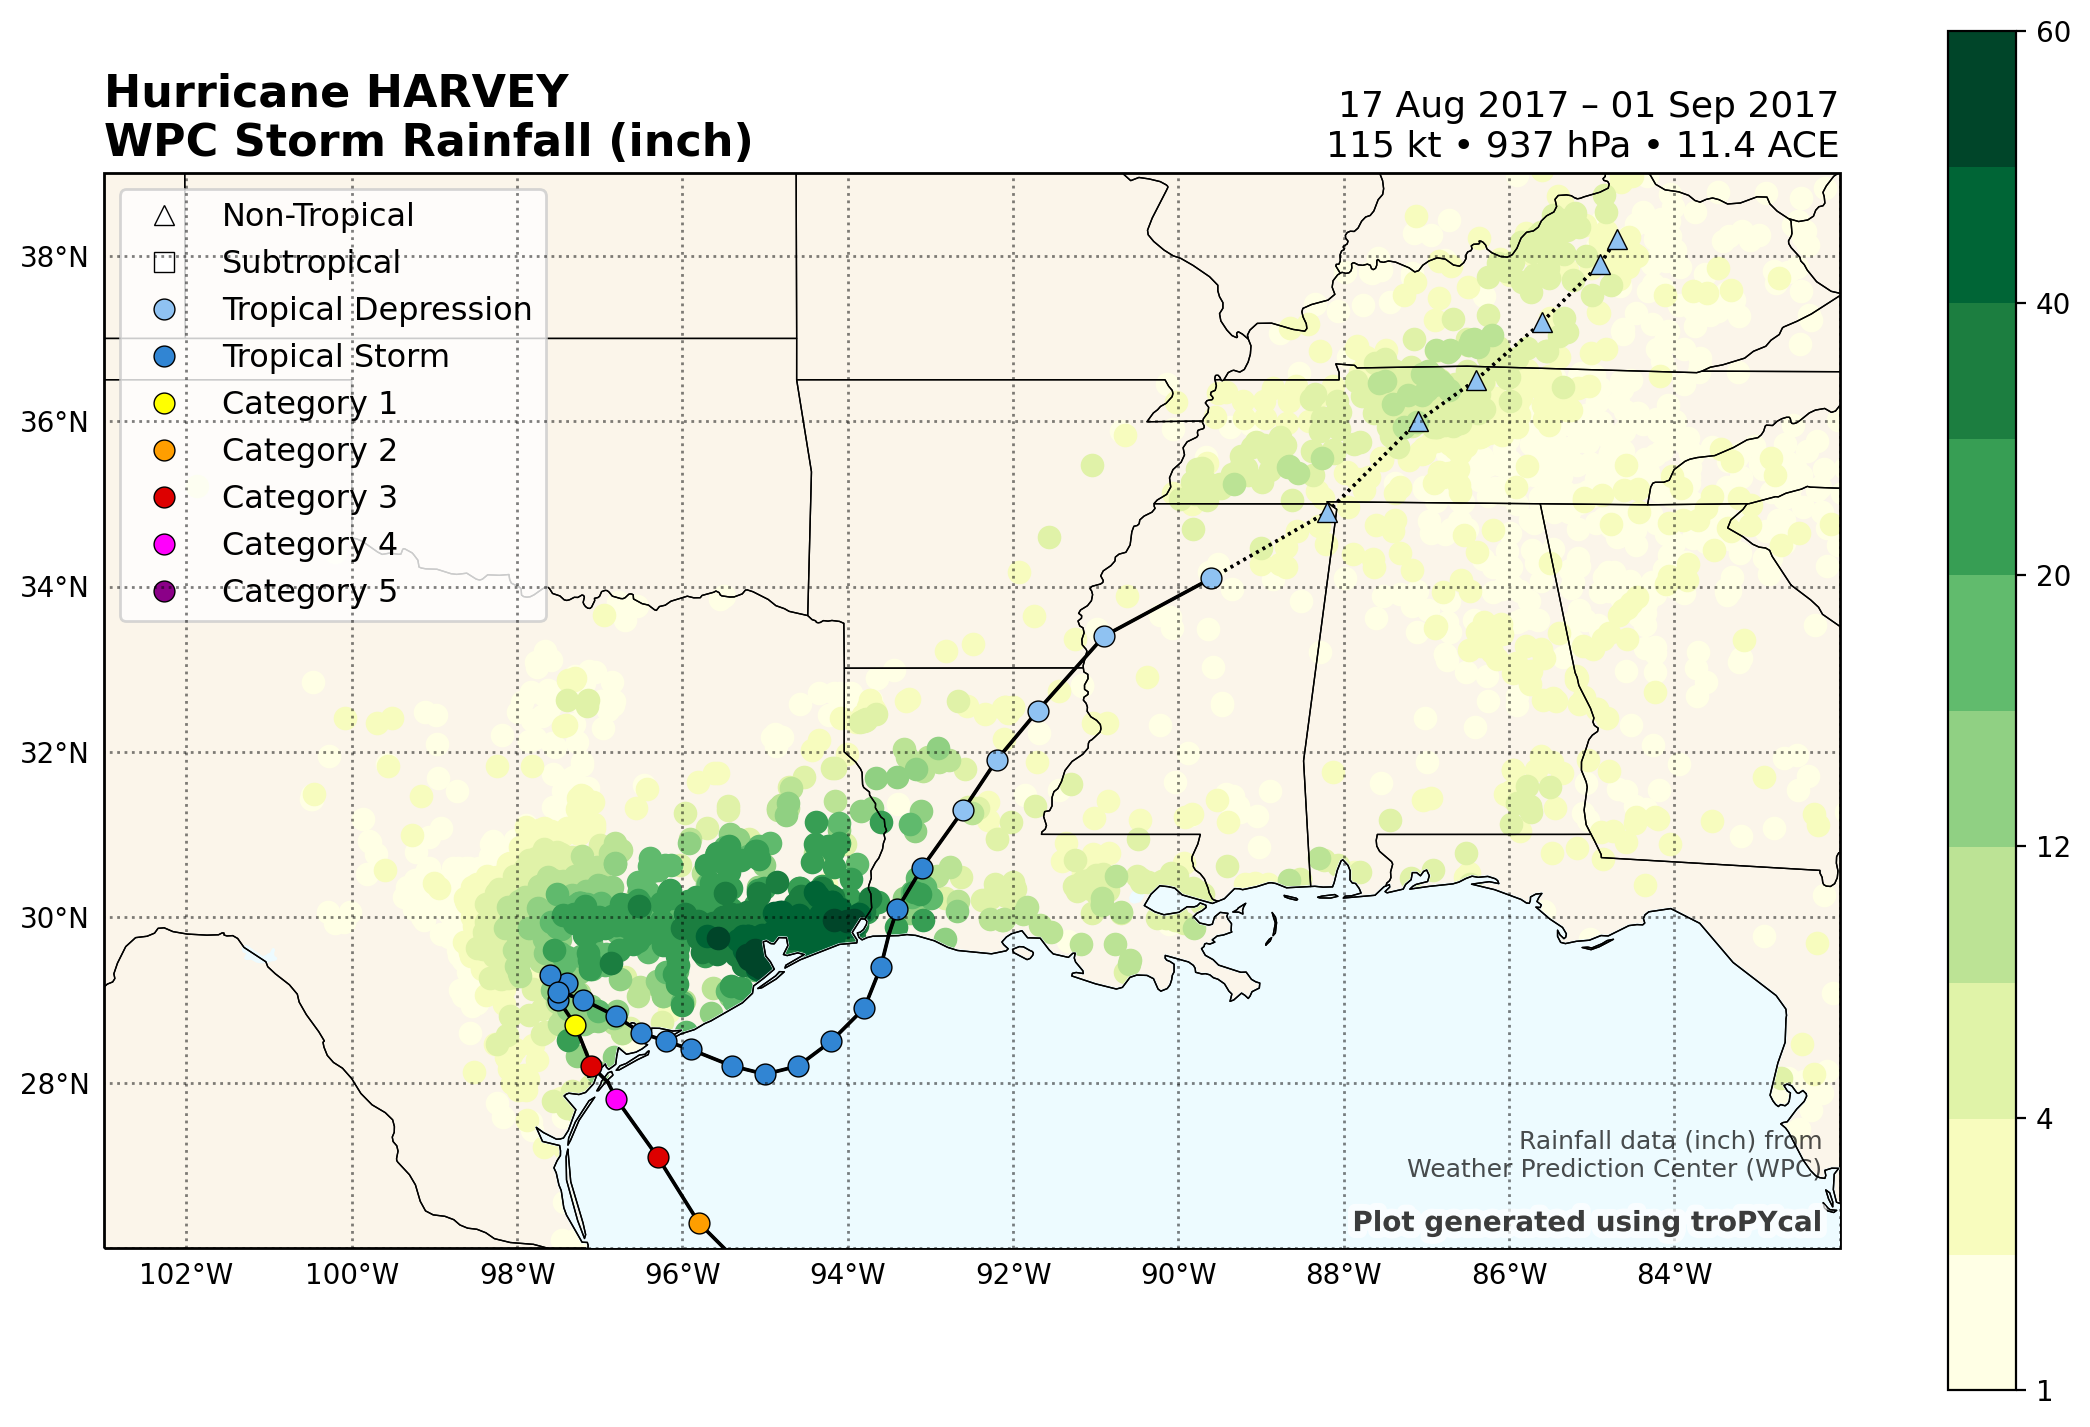

In [18]:
#Plot grid
levels = [1,2,4,8,12,16,20,30,40,50,60]
rain_obj.plot_rain(storm,levels=levels,domain={'s':26,'n':39,'w':-103,'e':-82})

Let's filter the plot to only rain observations over 30 inches:

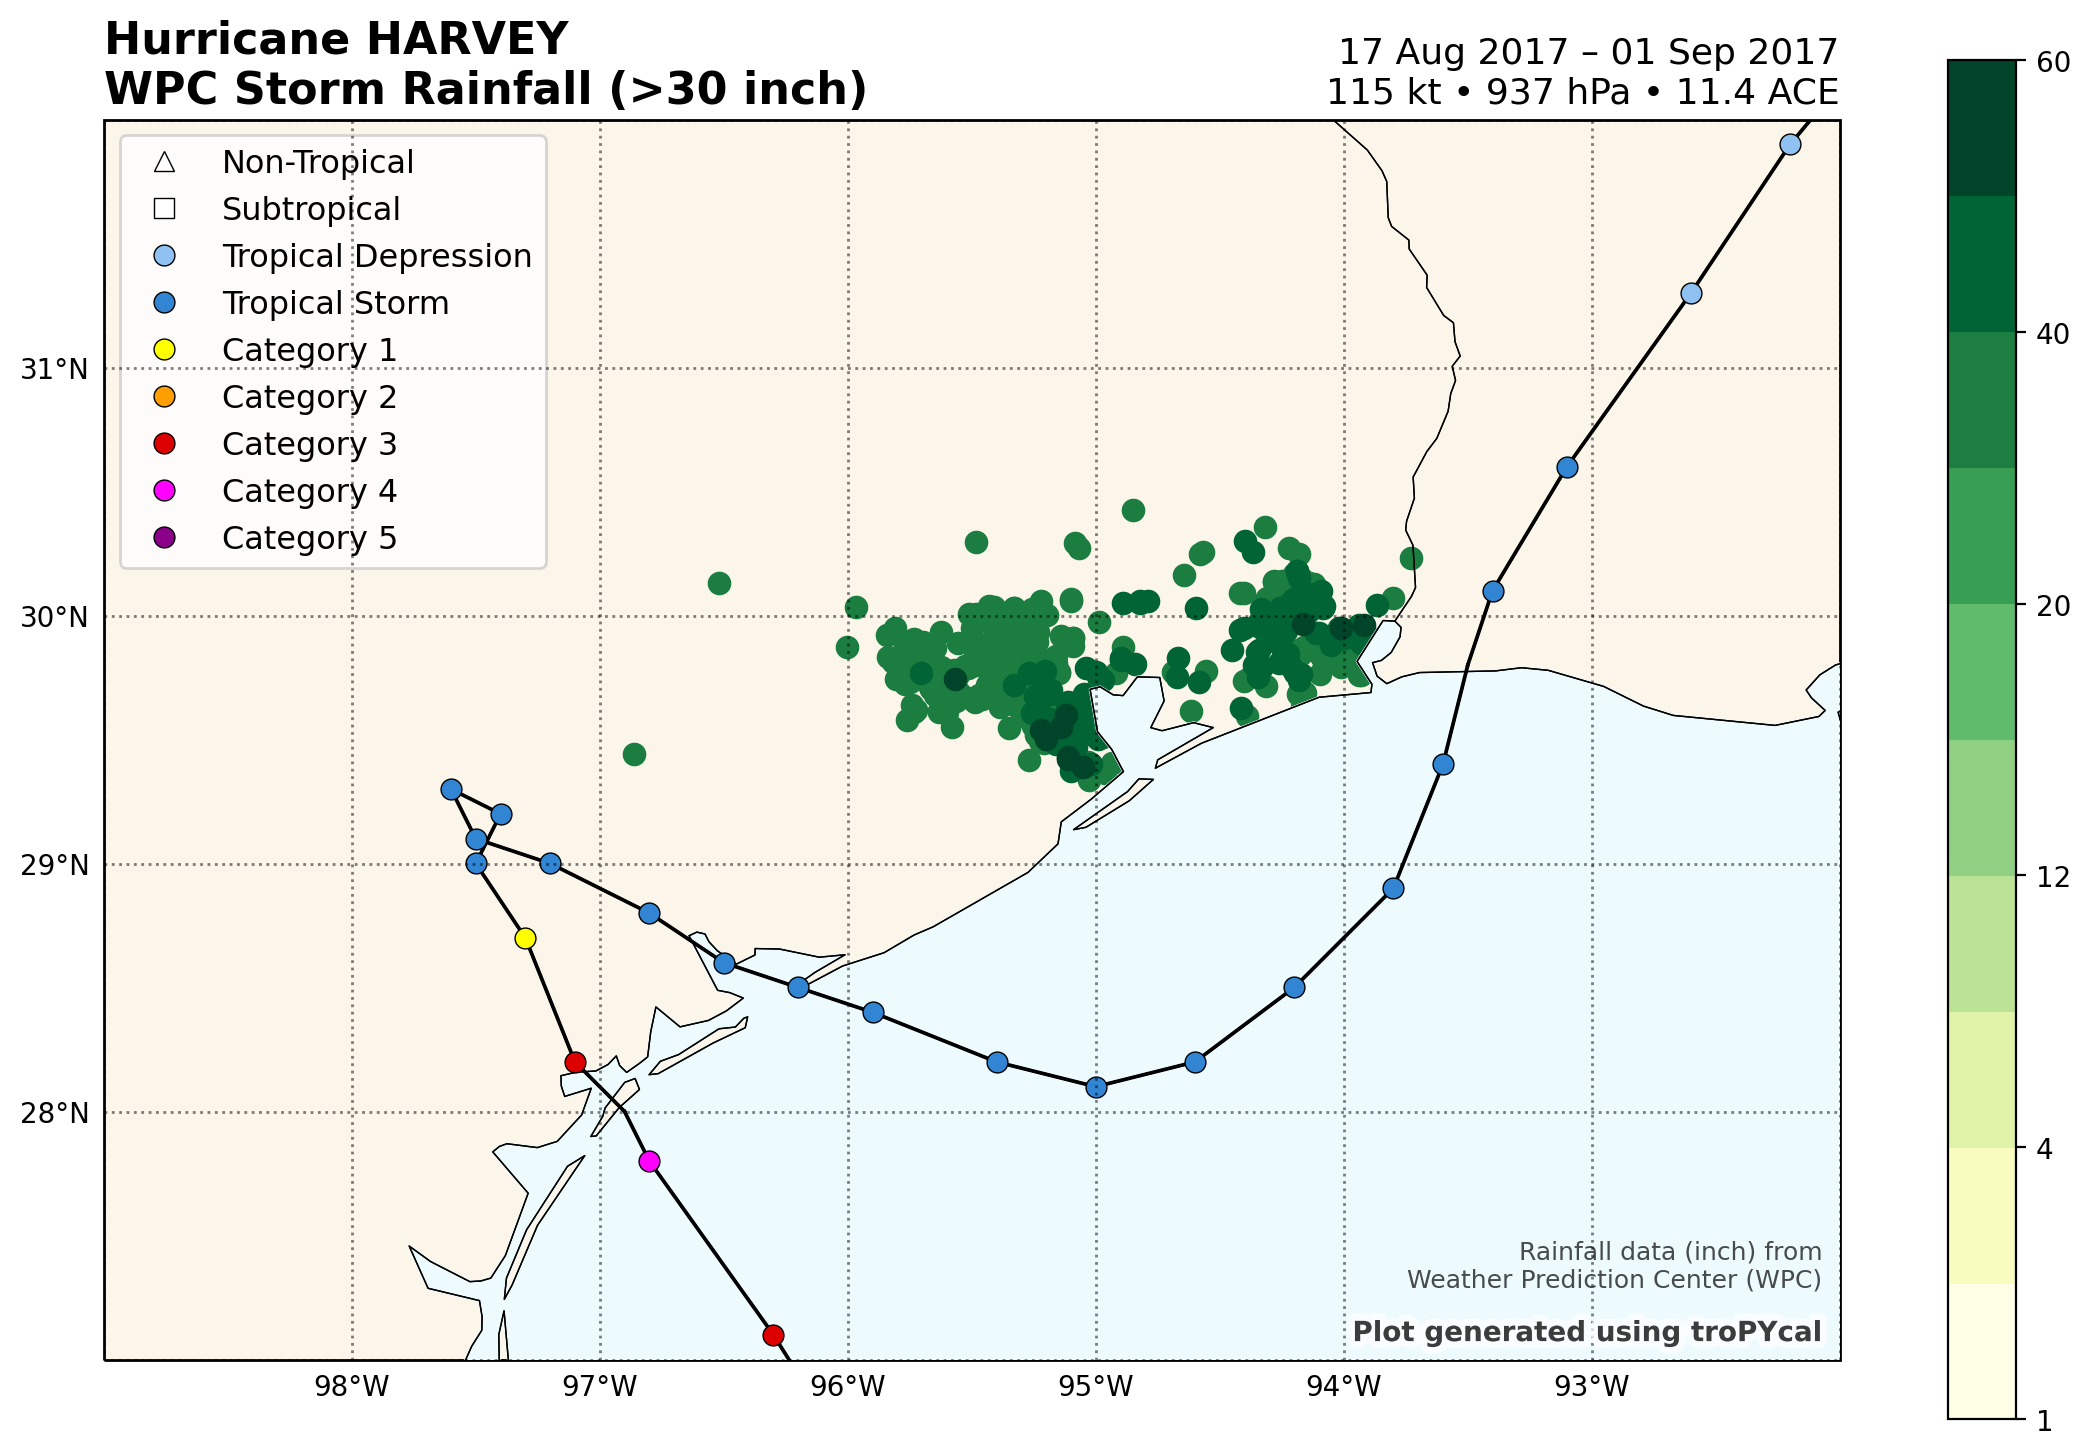

In [19]:
#Plot grid
levels = [1,2,4,8,12,16,20,30,40,50,60]
rain_obj.plot_rain(storm,levels=levels,minimum_threshold=30,domain={'s':27,'n':32,'w':-99,'e':-92})